The target of this project is to solve (approximately) the following two second-order boundary
value problems by means of the Galerkin method in Python.

### Problem 1
\begin{equation}
    \begin{cases}
        −u ''(x)+u(x)=f_1(x) , x\in(x_0 , x_1),\\
        u(x_0)=0, u (x_1)=0,
    \end{cases}
\end{equation}
where $x_0=0$, $x_1=1$ and $f_1(x)=(4\pi^2 (1−x^2)−x^2+3)\sin(2\pi x )+8\pi x \cos (2\pi x)$. 


### Problem 2
\begin{equation}
    \begin{cases}
        −(\alpha (x)u '(x))'+\gamma(x)u(x)=f_2(x) , x\in(x_0 , x_1),\\
        u(x_0)=0, u (x_1)=0,
    \end{cases}
\end{equation}
where $x_0=−1$, $x_1=1$ , $\alpha(x)=\sin (\frac{\pi x}{2})$, $\gamma(x)= 2x$ and $f_2(x)=\left( \frac{3\pi}{2}\cos(\frac{\pi x}{2})+(1−x)(\frac{\pi^2 }{2}\sin(\frac{\pi x}{2})+2 x)\right) \cos(\frac{\pi x}{2})−\pi.$ 


### Project Tasks
Solve the above two boundary value problems (Problem 1 and Problem 2) by means of the Galerkin method, using different sets of basis functions.

- Part 1: Linear approximation
    - 1.1) Visualize a set of linear finite elements for a given mesh (using a uniform knot sequence in the interval $[0,1]$ ).
    - 1.2) Build the Galerkin linear systems in NumPy format for Problem 1 and Problem 2, and solve them adequately.
    - 1.3) Build the Galerkin linear systems in SymPy format for Problem 1 and Problem 2, and solve them adequately.
    - 1.4) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$.
    - 1.5) Do a numerical convergence analysis of the error of the linear approximations uh in terms of the mesh-size $h$. Check that the approximation order is $O(h^2)$ . Hint: the unknown functions $u$ can be simulated by taking $u_H$ defined on a very fine mesh with $H\ll h$.
- Part 2: Spline approximation
    - 2.1) Visualize a set of B-spline finite elements for different degrees $p\geq1$ (say at least $p=1,2,3 $) on a given mesh (using a uniform knot sequence in the interval $[0,1]$ ).
    - 2.2) Build the Galerkin linear systems in NumPy format for Problem 1 and Problem 2, and solve them adequately.
    - 2.3) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$.
    - 2.4) Do a numerical convergence analysis of the error of the spline approximations $u_h$ in terms of the mesh-size $h$ for different degrees $p≥1$. What is the approximation order? How does it depend on the spline degree $p$?

#### Import all modules used below

In [1]:
import numpy as np
import scipy as sp
from scipy import interpolate as ipl
import scipy.integrate as integrate
import matplotlib.pyplot as plt
import sympy as sym

In [2]:
%matplotlib inline

# Part 1 - Finite Elements
## Problem 1 - Finite Elements - SciPy

### 1.1) Visualize a set of linear finite elements for a given mesh (using a uniform knot sequence in the interval $[0,1]$).       

We define a function that plots a set of $n$ linear finite elements on the uniform mesh on the interval $[0, 1]$. In this implementation we use the fact that `matplotlib.pyplot.plot` by default plots lines. 

In [3]:
def plot_elements_fast(n):
    '''Plots n finite elements on a uniform mesh on the interval [0,1]'''
    plt.figure(dpi=300)
    for k in range(n): #for each k, plotting the shape of the k-th finite element at the appropriate knots
        plt.plot([0, k/(n+1), (k+1)/(n+1), (k+2)/(n+1), 1], [0, 0, 1, 0, 0])
    plt.plot(np.linspace(0,1,n+2), np.zeros(n+2), color='#A0A0A0') #grey line
    plt.plot(np.linspace(0,1,n+2), np.zeros(n+2), 'o', color='#000000')# black dots

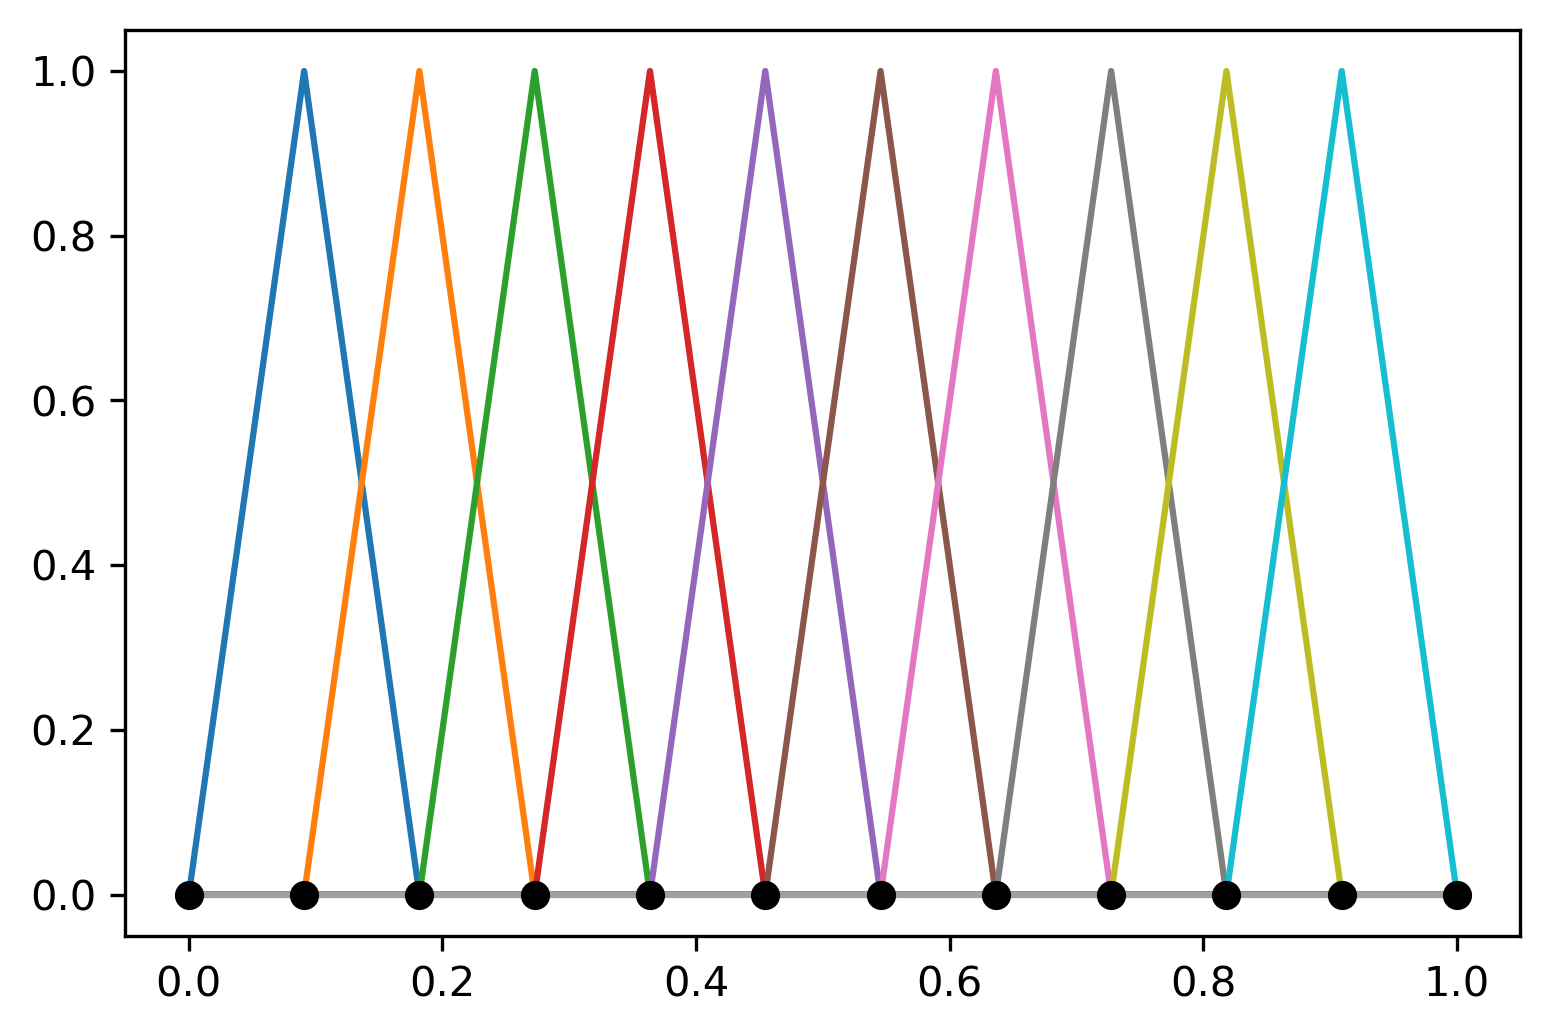

In [4]:
plot_elements_fast(10)

### 1.2) Build the Galerkin linear systems in NumPy format for Problem 1 (and Problem 2), and solve them adequately.

Dividing code in functions makes it easier to read and easier to recycle. We introduce two auxiliary functions to compute $f_1(x)$ and to compute $f_1(x)\varphi_k(x)$, the second of which we need to feed `integrate.quad` to get the values in $F$ in the Galerkin linear system. We could probably merge them in one funcition, but we'll need a separate `compute_f(x)` later anyway.

In [5]:
def compute_f(x):
    '''Returns the value of f at x'''
    return (((2*np.pi)**2)*(1-x**2)-x**2+3)*np.sin(2*np.pi*x)+ 8*np.pi*x*np.cos(2*np.pi*x)

In [6]:
def compute_f_phi_k(k, N, x):
    '''Returns the value of f*phi_k at x'''
    if x < (k-1)/N:
        return 0
    elif x < k/N:
        return (x*N-k+1)*compute_f(x)
    elif x < (k+1)/N:
        return (k+1-(x*N))*compute_f(x)
    else:
        return 0

We can then easily write a very simple function which computes the $L^2((0,1))$ scalar product of $f_1(x)$ and $\varphi_k(x)$:

In [7]:
def product_f(n, k):
    '''Computes the L^2 scalar product of f and phi_k.'''
    N=n+1    
    integr=lambda x: compute_f_phi_k(k, N, x)
    return integrate.quad(integr, (k-1)/N, (k+1)/N)[0]

In [8]:
print(product_f(399, 55))

0.08490583939268054


Finally we can define a function to compute the result of the Galerkin problem. To compute A, we use the exact integral of the two functions corresponding to the only two relevant cases (if they are not consecutive, the domains are disjoint and the integral is zero) as they are quite easy to compute with pen and paper.

In [9]:
def galerkin(n):
    '''Solves the Galerkin problem for problem 1'''
    a=np.zeros((n,n)) # Building the matrix A
    N=n+1
    for i in range(0, n):
        a[i, i]=2*N+(2/(3*N))
    for i in range(0, n-1):
        a[i, i+1]=1/(6*N) -N
        a[i+1, i]=a[i, i+1]    
    f=[product_f(n,i) for i in range(1, n+1)] # Building the vector F
    x=sp.linalg.solve(a, f, assume_a='sym') # Solving the linear system
    return x

In [10]:
print(galerkin(100))

[ 0.06216404  0.12405108  0.18538552  0.24589458  0.30530961  0.36336753
  0.4198121   0.47439523  0.52687824  0.57703303  0.62464325  0.66950536
  0.71142966  0.75024122  0.78578073  0.81790528  0.84648909  0.87142404
  0.89262024  0.9100064   0.92353017  0.93315831  0.93887685  0.94069107
  0.93862539  0.93272322  0.92304662  0.90967592  0.89270924  0.8722619
  0.84846572  0.82146829  0.79143212  0.75853367  0.72296243  0.68491978
  0.64461791  0.60227859  0.55813201  0.51241541  0.46537184  0.41724878
  0.36829678  0.3187681   0.26891532  0.21898992  0.16924096  0.11991368
  0.0712482   0.02347816 -0.02317048 -0.06848071 -0.11224563 -0.15426954
 -0.19436901 -0.23237383 -0.26812796 -0.30149027 -0.33233536 -0.36055412
 -0.38605435 -0.40876114 -0.4286173  -0.44558353 -0.45963863 -0.4707795
 -0.47902108 -0.4843962  -0.48695529 -0.48676601 -0.48391275 -0.47849608
 -0.47063205 -0.46045145 -0.44809893 -0.43373205 -0.41752031 -0.39964399
 -0.38029304 -0.35966585 -0.33796794 -0.31541067 -0.2

Can this be done better? Yes! We can use a solver made for banded matrices: this will greatly improve how fast we can compute a finer mesh. (while at the same time using less memory)

In [2]:
def galerkin_fast(n):
    '''Solves the Galerkin problem for problem 1 - banded matrix version'''
    ab=np.zeros((3,n)) # Building the banded matrix A, stored in a (3, n) rectangular matrix
    N=n+1
    for i in range(0, n):
        ab[1, i]=2*N+(2/(3*N))
    for i in range(0, n-1):
        ab[0,1:n]=1/(6*N) -N
        ab[2, 0:n-1]=ab[0, 1:1]      
    f=[product_f(n,i) for i in range(1,n+1)] # Building the vector F
    x=sp.linalg.solve_banded((1, 1), ab, f) # Solving the linear system
    return x

In [12]:
print(galerkin_fast(100))

[ 0.06216404  0.12405108  0.18538552  0.24589458  0.30530961  0.36336753
  0.4198121   0.47439523  0.52687824  0.57703303  0.62464325  0.66950536
  0.71142966  0.75024122  0.78578073  0.81790528  0.84648909  0.87142404
  0.89262024  0.9100064   0.92353017  0.93315831  0.93887685  0.94069107
  0.93862539  0.93272322  0.92304662  0.90967592  0.89270924  0.8722619
  0.84846572  0.82146829  0.79143212  0.75853367  0.72296243  0.68491978
  0.64461791  0.60227859  0.55813201  0.51241541  0.46537184  0.41724878
  0.36829678  0.3187681   0.26891532  0.21898992  0.16924096  0.11991368
  0.0712482   0.02347816 -0.02317048 -0.06848071 -0.11224563 -0.15426954
 -0.19436901 -0.23237383 -0.26812796 -0.30149027 -0.33233536 -0.36055412
 -0.38605435 -0.40876114 -0.4286173  -0.44558353 -0.45963863 -0.4707795
 -0.47902108 -0.4843962  -0.48695529 -0.48676601 -0.48391275 -0.47849608
 -0.47063205 -0.46045145 -0.44809893 -0.43373205 -0.41752031 -0.39964399
 -0.38029304 -0.35966585 -0.33796794 -0.31541067 -0.2

How much faster than `galerkin(n)` is `galerkin_fast(n)`? Quite a lot! 

In [13]:
%timeit galerkin(10000)
%timeit galerkin_fast(10000)

8.88 s ± 47 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
2.44 s ± 63.8 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


This is indeed a huge improvement if one considers that both functions have to build A and F from scratch. 

### 1.3) Build the Galerkin linear system in SymPy format for Problem 1 (and Problem 2), and solve them adequately.

The SymPy implementation is very similar. Two functions get introduced: the first one computes the integral $\int_{[0,1]} f\varphi_k \,dx$, the second one solves the Galerkin linear problem. The integrals in the matrix $A$ are again skipped by just using the exact result instead. 

In [14]:
def compute_integral_f_phi_k(k, N):
    '''Computes the L^2 scalar product of f and phi_k - SymPy version.'''
    x = sym.symbols('x')
    f_sym=(((2*sym.pi)**2)*(1-x**2)-x**2+3)*sym.sin(2*sym.pi*x)+ 8*sym.pi*x*sym.cos(2*sym.pi*x)
    before= (x*N-k+1)*f_sym # the symbolic value of the integrand before the (k+1)-th knot (including 0)
    after = (k+1-(x*N))*f_sym # the symbolic value of the integrand after the (k+1)-th knot 
    return sym.integrate(before, (x, (k-1)/N, k/N))+sym.integrate(after, (x, k/N, (k+1)/N))#Computing and returning the integral

In [15]:
def galerkin_sym(n):    
    '''Solves the Galerkin problem for problem 1 - SymPy version'''
    N=n+1
    a=sym.banded({-1:1/(6*N)-N, 0:2*N+(2/(3*N)), 1:1/(6*N)-N}, rows=n, cols=n)# Building A
    f=sym.Matrix(n, 1, lambda i,j: compute_integral_f_phi_k(i+1, N)) # Building F
    x=a.LUsolve(f) #Solving the Galerkin linear system
    return x

In [16]:
x=galerkin_sym(8)
x.evalf()

Matrix([
[ 0.635470487188474],
[ 0.937087295679432],
[ 0.770550278351851],
[ 0.274728327461373],
[-0.236687411677257],
[ -0.48159129507053],
[-0.389435427812359],
[-0.135034763275769]])

We can check that the result is correct by comparing it with the result we get when using the SciPy implementation, and see that it is indeed the case: 

In [17]:
print(galerkin_fast(8))

[ 0.63547049  0.9370873   0.77055028  0.27472833 -0.23668741 -0.4815913
 -0.38943543 -0.13503476]


The implementation could be made faster by implementing the LU-solver for banded matrices in SymPy, which is not available by default, but most of the computation time is spent computing the integrals in $F$, hence the improvement this time is marginal at best.  

In [18]:
def Thomas_algorithm_tridiagonal_solve(a, b, c, f):
    """
    Solves the system Ax=f where A is a triagonal matrix using Thomas's algorithm (a linear-time algorithm for such equation 
    when A is tridiagonal). The algorithm is just a fast implementation of the LDM^T decomposition for the matrix A.
    For more details, see "Quarteroni, Sacco, Saleri, Gervasio - Matematica Numerica, 4a edizione, page 95 and page 98"
    """
    n=a.shape[0]
    b=sym.ones(1).col_join(b)
    c=c.col_join(sym.ones(1))
    gamma=sym.ones(n, 1)
    gamma[0]=1/a[0]
    for i in range(1,n):
        gamma[i]=1/(a[i]-b[i]*gamma[i-1]*c[i-1])
    y=sym.zeros(n, 1)
    y[0]=gamma[0]*f[0]
    for i in range(1,n):
        y[i]=gamma[i]*(f[i]-b[i]*y[i-1])
    x=sym.zeros(n,1)
    x[n-1]=y[n-1]
    for i in range(n-2, -1, -1):
        x[i]=y[i]-gamma[i]*c[i]*x[i+1]
    return x

In [19]:
def galerkin_sym_fast(n):
    '''Solves the Galerkin problem for problem 1 - SymPy+banded matrix version'''
    N=n+1
    a_short_diag=sym.ones(n-1, 1)*(1/(6*N)-N) # sub-diagonal of A
    a_long_diag=sym.ones(n, 1)*(2*N+(2/(3*N))) # diagonal of A
    f=sym.Matrix(n, 1, lambda i,j: compute_integral_f_phi_k(i+1, N)) # computing F
    x=Thomas_algorithm_tridiagonal_solve(a_long_diag, a_short_diag, a_short_diag, f) #solving the linear system
    return x

We can check that indeed this yields the same result as before and measure the difference in speed: 

In [20]:
x=galerkin_sym_fast(8)
x.evalf()

Matrix([
[ 0.635470487188473],
[ 0.937087295679432],
[ 0.770550278351851],
[ 0.274728327461373],
[-0.236687411677257],
[-0.481591295070531],
[-0.389435427812359],
[-0.135034763275769]])

In [21]:
%timeit galerkin_sym(8)
%timeit galerkin_sym_fast(8)

12.7 s ± 272 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)
12.4 s ± 349 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


### 1.4) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$ .

Visualizing the functions obtained is just a couple of lines of code. Again, one can use the fact that `matplotlib` draws lines by default, together with the fact that the value of $u_h$ at the knots are exactly the coefficients in front of the $\varphi_k$:

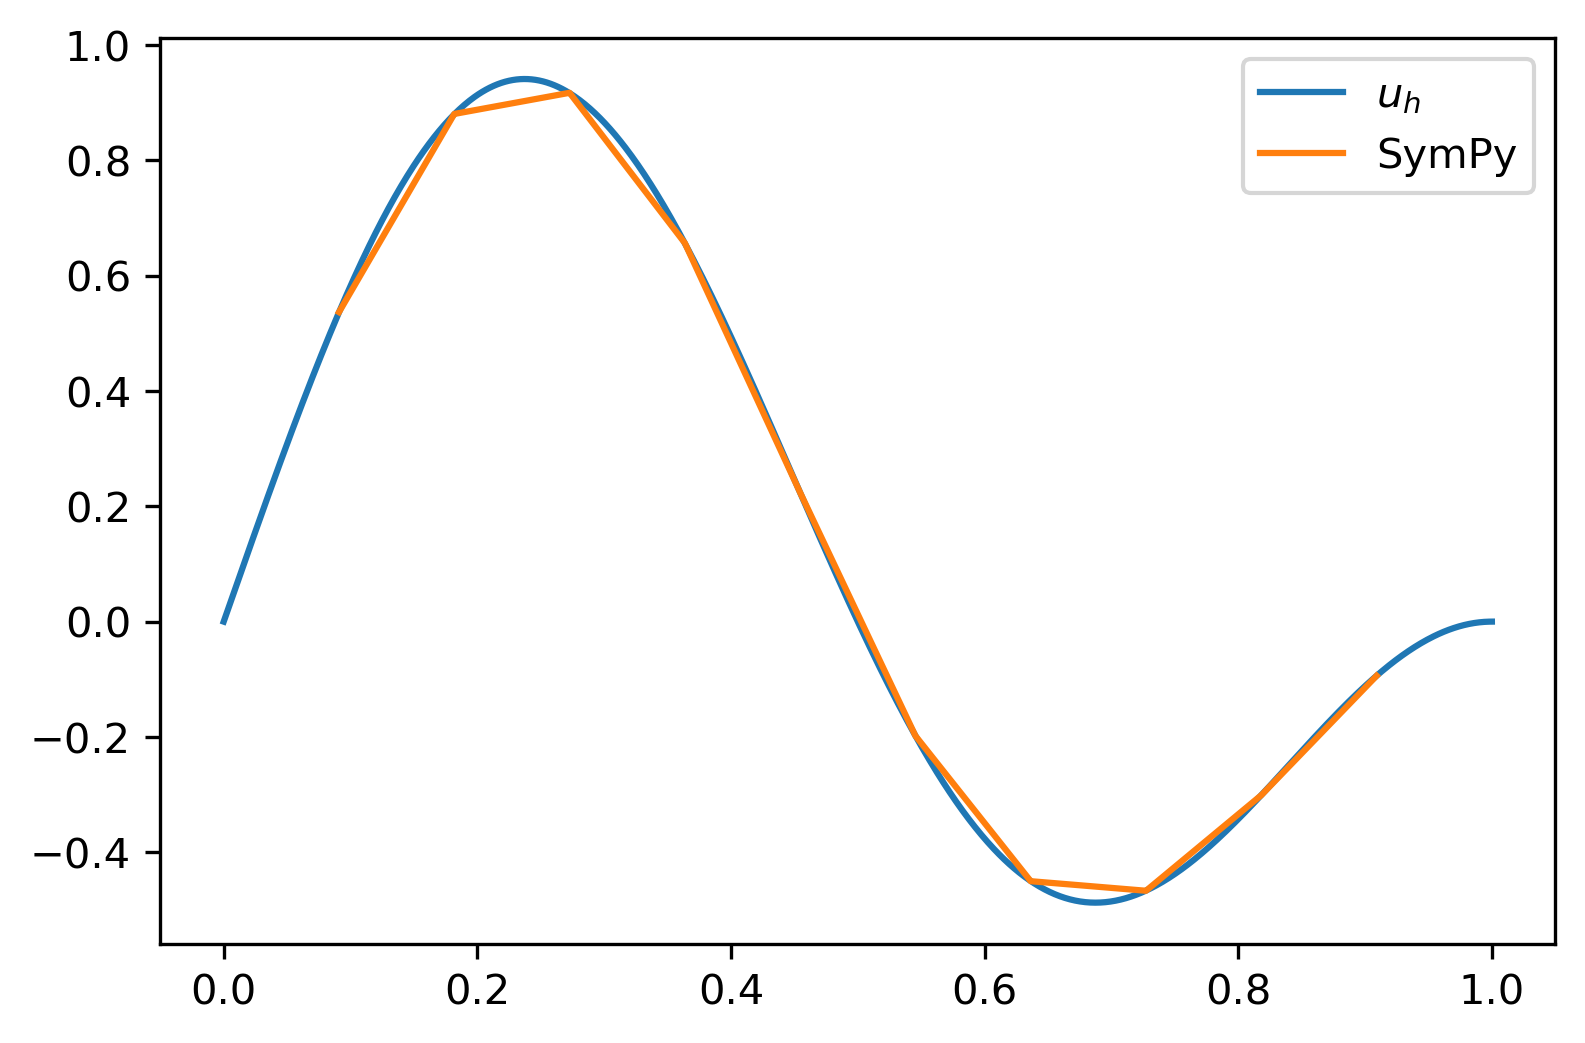

In [22]:
x=np.linspace(0, 1, 1000+2) # building the mesh 
u_h=np.zeros(1000+2)
u_h[1:-1] = galerkin_fast(1000) #solving the Galerkin linear system
plt.figure(dpi = 300)
plt.plot(x, u_h) #plotting the NumPy solution
plt.plot(np.linspace(0, 1, 12)[1:-1], galerkin_sym_fast(10)) #plotting the SymPy solution (with a more reasonable mesh size)
plt.legend(['$u_h$', 'SymPy'])

Looking at the equation of Problem 1 we find that its exact solution is $(1-x^2)\sin(2 \pi x)$, __[as one can check](https://www.wolframalpha.com/input?i2d=true&i=-+D%5B%5C%2891%29%5C%2840%291-Power%5Bx%2C2%5D%5C%2841%29Sin%5B2%CF%80x%5D%5C%2893%29%2C%7Bx%2C2%7D%5D%2B%5C%2891%29%5C%2840%291-Power%5Bx%2C2%5D%5C%2841%29Sin%5B2%CF%80x%5D%5C%2893%29)__. Comparing the solution we found against it we can see that, indeed, our solution is correct:

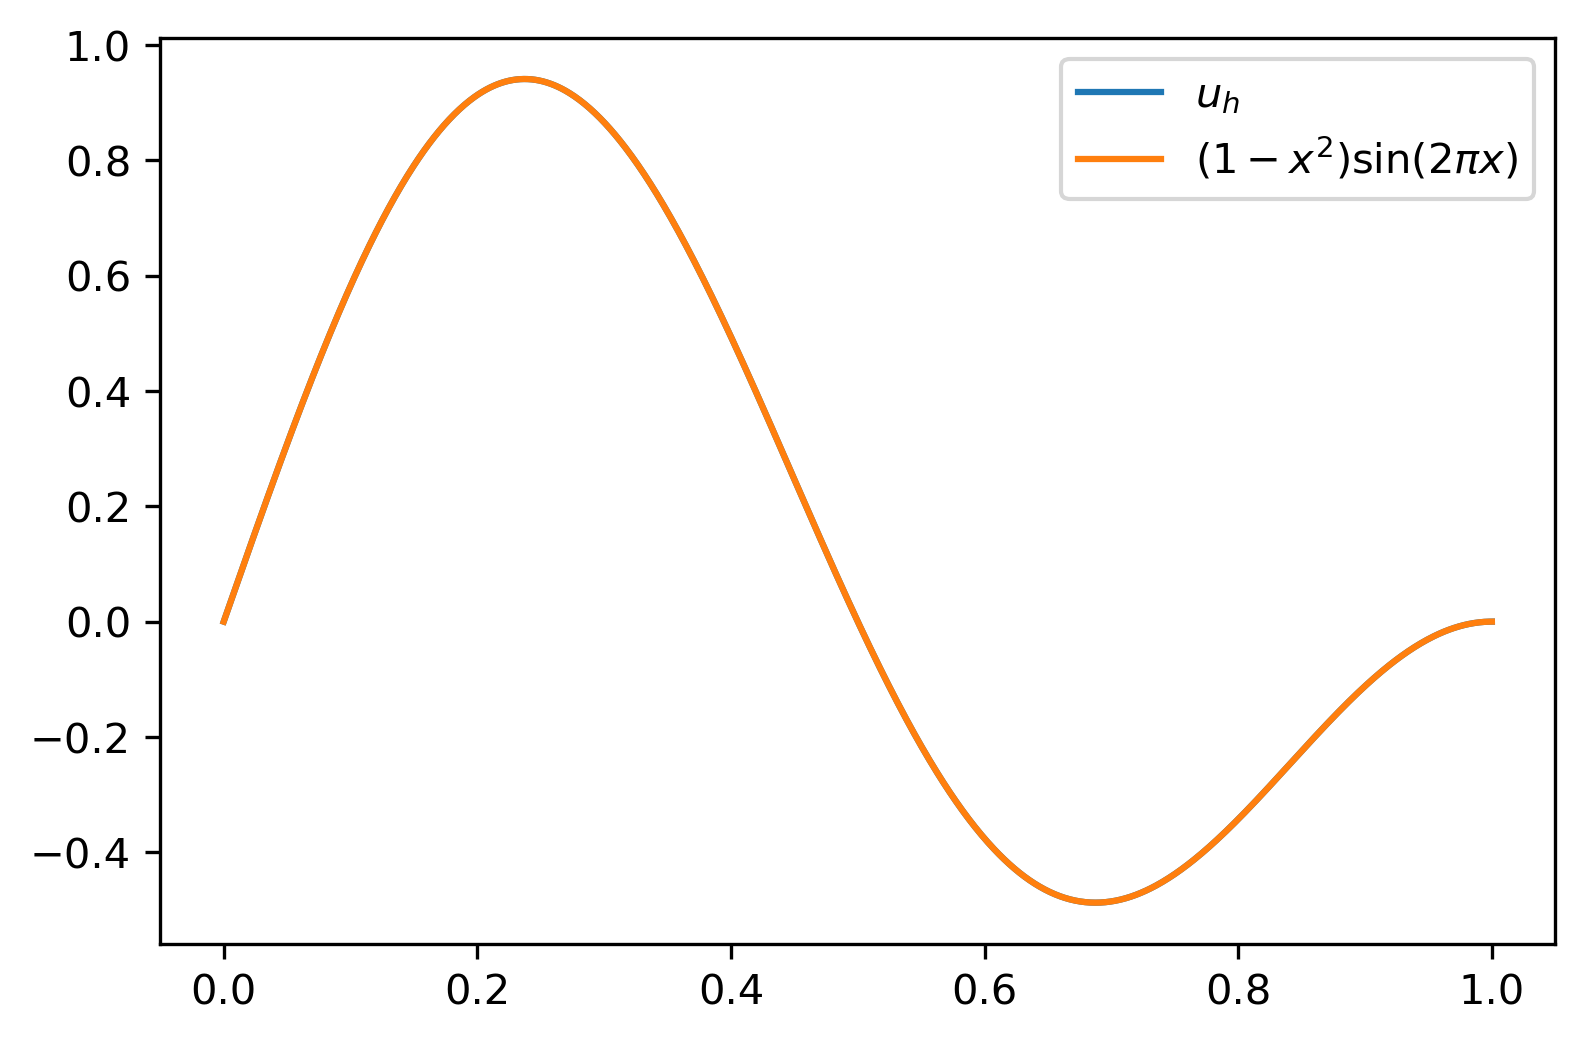

In [23]:
plt.figure(dpi = 300)
x=np.linspace(0, 1, 1000+2) #building the mesh
u_h=np.zeros(1000+2)
u_h[1:-1] = galerkin_fast(1000) #solving the Galerkin linear system
plt.plot(x, u_h)#plotting the Galrekin solution
plt.plot(x, (1-x**2)*np.sin(2*np.pi*x)) #plotting the exact solution
plt.legend(['$u_h$', '$(1-x^2)\sin(2 \pi x)$'])

Indeed, the error we get is extremely small:

In [24]:
print(np.max(np.abs((1-x**2)*np.sin(2*np.pi*x)-u_h)))

7.577444505191266e-08


### 1.5) Do a numerical convergence analysis of the error of the linear approximations $u_h$ in terms of the mesh-size $h$ . Check that the approximation order is $O(h^2)$. Hint: the unknown functions $u$ can be simulated by taking $u_H$ defined on a very fine mesh with $H\ll h$.

Having gotten extremely lucky and having managed to find the exact solution, there is no need to approximate $u$ using a very fine mesh. Also, $1-$splines are finite elements, as we can quickly check: (notice we need `extrapolate=False` to properly use `ipl.BSpline.basis_element`, otherwise the lines would continue below 0; we're also using the fact that `plt.plot` ignores `NaN`s, to avoid having to change `x` at each step)

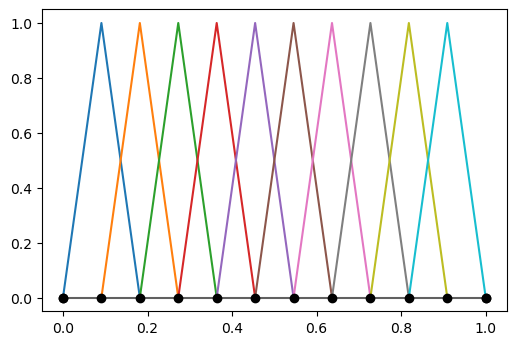

In [25]:
plt.figure(dpi = 100)
x = np.linspace(0, 1, 12)# building the mesh
knots = np.zeros(14)
knots[1:13]=x
knots[13]=1.0    
for i in range(10):# creating the spline elements and plot them
    spline = ipl.BSpline.basis_element(knots[i+1:i+4], extrapolate=False)
    plt.plot(x, spline(x))   
plt.plot(knots, np.zeros(14), color='#606060') # line and dots at the bottom
plt.plot(knots, np.zeros(14), 'o', color='#000000') 

Hence, we can borrow `sp.interpolate.BSpline(knots, coefficients, 1)` from Part 2 for a more granular approximation of the error (i.e. estimating also outside the value at the knots). We repeatedly test the exact solution against the solution obtained with `galerkin_fast(k)` for all the $k$ contained in an input list of integers `testagainst`. Obviously, the NumPy version of the problem is used because it manages to run much faster. 

In [26]:
def test_galerkin(testagainst=[4, 8, 16, 32, 64, 128, 256, 512, 1024, 2048, 4096]):
    '''Performs a numerical convergence analysis for the Galerkin method on problem 1 and plots the result'''
    n=len(testagainst)
    
    x=np.linspace(0, 1, 20*testagainst[n-1]+2) #points where we test and exact solution
    exact=(1-x**2)*np.sin(2*np.pi*x)

    err=[]
    for k in testagainst: #for each mesh size in testagainst:
        test=np.zeros(k+2)
        test[1:-1]=galerkin_fast(k) #get the coefficients
        
        knots = np.zeros(k+4) #get the approximating function
        knots[1:k+3]=np.linspace(0, 1, k+2)
        knots[k+3:]=1.0   
        B = sp.interpolate.BSpline(knots, test, 1)
        
        err.append(np.max(np.abs(exact-B(x))))  #get the error of the approximation and save it in err
    plt.figure(dpi=300) #plotting the error and a reference succession decreasing exactly as O(h^2)
    plt.semilogy(err, '-o')
    plt.semilogy([0.1/((testagainst[i]/testagainst[0])**2) for i in range(n)], 'k--o')
    plt.legend(('Error', 'Reference'))
    return np.array(err)

Here, $h=\frac{1}{\mathtt{testagainst[i]}+1}$ and the error at $n=4$ is $~0.1$, so doubling `testagainst` at 
each iteration we get that the expected error is $\sim 0.1 \frac{\mathtt{testagainst[0]}^2}{\mathtt{testagainst[i]^2}}$
which is plotted against the actual error using `matplotlib.pyplot.semilogy` to keep it readable 
despite the big difference in order of magnitude. 

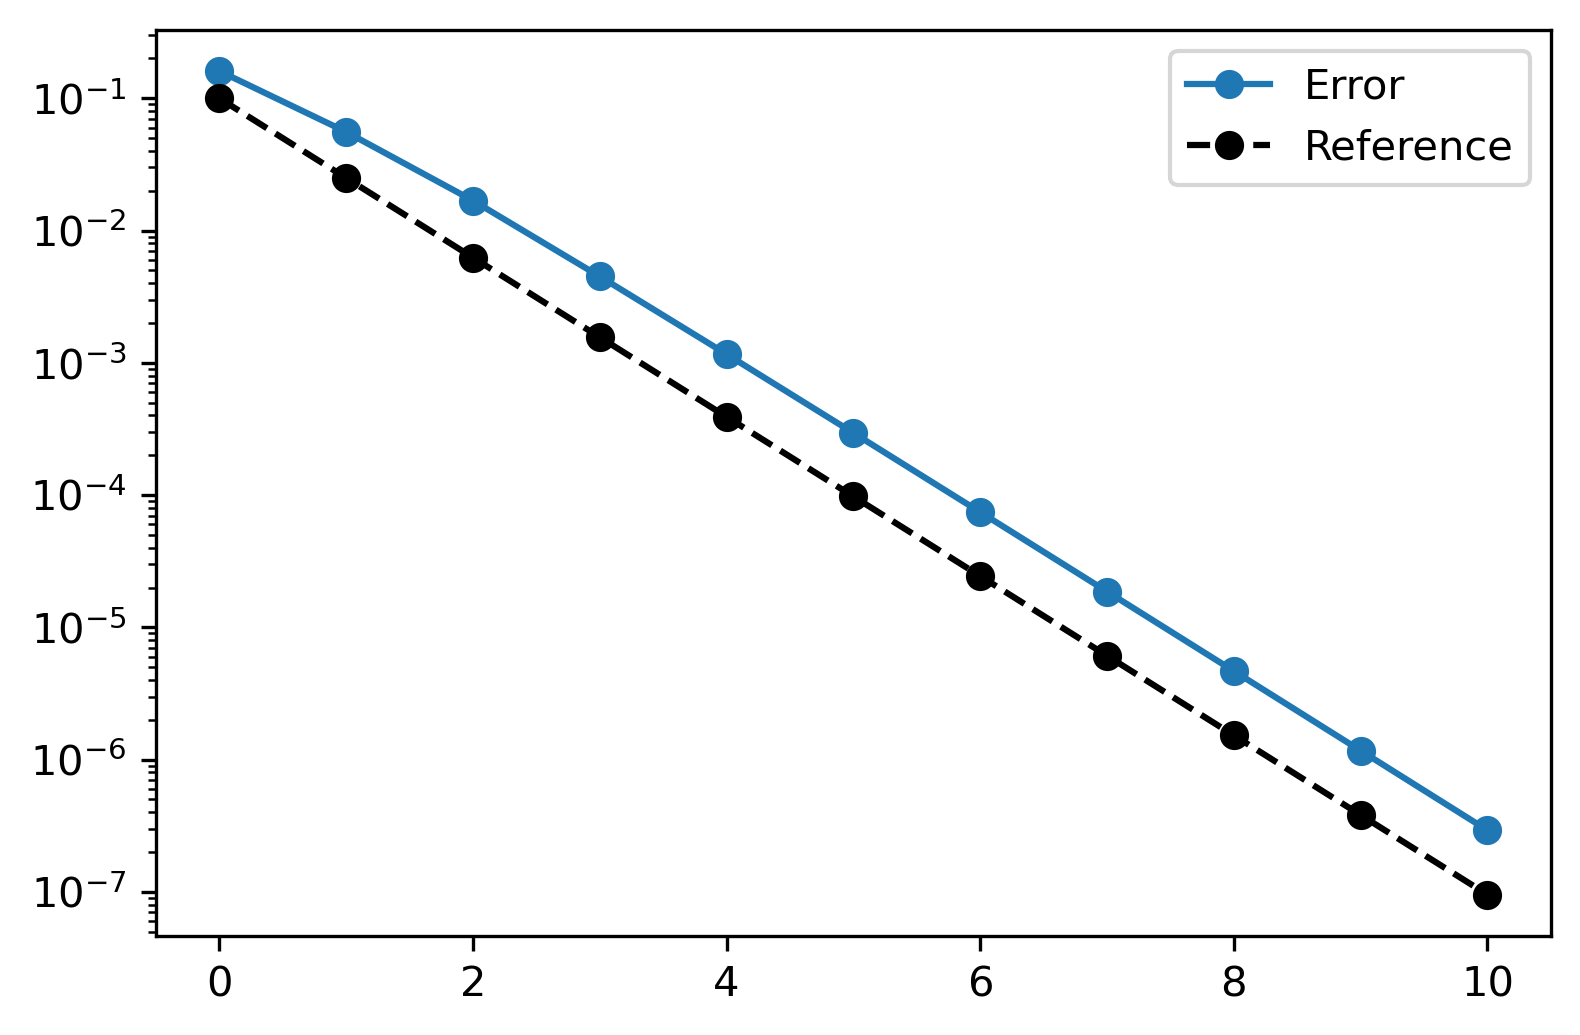

In [27]:
err=test_galerkin()

Also, $\frac{\mathtt{testagainst[i]}}{\mathtt{testagainst[i+1]}}=\frac{1}{2}$, thus we are dividing $h$ by $2$ 
on each iteration. Hence, the error should improve by $2^r$ for some exponent $r$, assuming that the error is $O(h^r)$. We can compute $r=\log_2(2^r)=log_2(\frac{\mathtt{err[i]}}{\mathtt{err[i+1]}})$. If the error is $O(h^2)$, we would expect $r\sim 2$ which indeed seems to be the case.

In [28]:
error_order = np.log2(err[:-1]/err[1:])
print(error_order)

[1.52855359 1.72484351 1.905267   1.95339123 1.97713924 1.98869016
 1.99437901 1.99727605 1.99905586 1.99912001]


## Problem 2 - Finite Elements - SciPy

### A note on problem 2

The equation of problem 2 is 
\begin{equation}
    \begin{cases}
        −(\alpha (x)u '(x))'+\gamma(x)u(x)=f_2(x) , x\in(x_0 , x_1),\\
        u(x_0)=0, u (x_1)=0,
    \end{cases}
\end{equation}
where $x_0=−1$, $x_1=1$ , $\alpha(x)=\sin (\frac{\pi x}{2})$, $\gamma(x)= 2x$ and $f_2(x)=\left( \frac{3\pi}{2}\cos(\frac{\pi x}{2})+(1−x)(\frac{\pi^2 }{2}\sin(\frac{\pi x}{2})+2 x)\right) \cos(\frac{\pi x}{2})−\pi.$ 

We notice both $\alpha$ and $\gamma$ are odd functions. This implies that when one considers an even finite element $\varphi$ centered at 0 (i.e. one with knots $(-k, 0, k)$): 

\begin{equation}
    a(\varphi,\varphi)=\int_{-1}^{1}  \alpha(x)\varphi'(x)\varphi'(x)+\int_{-1}^{1}  \gamma(x)\varphi(x)\varphi(x)=0 
\end{equation}

as both $[\varphi'(x)]^2$ and $[\varphi(x)]^2$ are even functions, thus $\alpha(x)[\varphi'(x)]^2$ and $\gamma(x)[\varphi(x)]^2$ are odd functions, and integrating an odd function on an interval symmetric with respect to $0$ yields always $0$. This means it is impossible to find a constant $a_0>0$ such that 

\begin{equation}
    |a(\varphi,\varphi)|\geq a_0\Vert\varphi\Vert_V^2 
\end{equation}

Hence, the required coercivity in the Lax-Milgram theorem (used for existence and uniqueness of a solution) is missing unless one limits $V$ to the space of finite elements (or $p$-splines) where the mesh is such that there is not a finite element (or $p$-spline) centered on $0$

### 1.2) Build the Galerkin linear systems in NumPy format for (Problem 1 and) Problem 2, and solve them adequately.

We can start by defining the functions equivalent to `compute_f` and `product_f`. We separate them to make the resulting code more readable and to be able to recycle `compute_f_2` in Part 2.  

In [29]:
def compute_f_2(x):
    '''Returns the value of f_2 at x'''
    return ( 1.5*np.pi*np.cos(np.pi*x*0.5) + (1-x)*(0.5*(np.pi**2)*np.sin(np.pi*x*0.5)+2*x) )*np.cos(np.pi*x*0.5)-np.pi

In [30]:
def product_f_2(n, k):
    '''Computes the L^2 scalar product of f and phi_k.'''
    knots=np.ones(n+4)#allocates knots
    knots[1:-1]=np.linspace(-1, 1, n+2)
    knots[0]=-1
    c=np.zeros(n+2) #creating the spline and its derivative
    c[k+1]=1.
    phi=ipl.BSpline(knots, c, 1)
    integr=lambda x: compute_f_2(x)*phi(x) #callable element computing f_2(x)*\phi(x)
    return integrate.quad(integr,  knots[k+1], knots[k+3])[0] #computing and returning the integral

For a simpler (albeit slower) implementation `interpolate.BSpline` is used. A function is also introduced to compute the coefficients of the matrix $A$: 

In [31]:
def product_a(n, k1, k2):
    '''Computes the a-scalar product of phi_k1 and phi_k2.'''
    knots=np.ones(n+4) #allocates knots
    knots[1:-1]=np.linspace(-1, 1, n+2)
    knots[0]=-1
    
    c1=np.zeros(n+2) #first spline and its derivative
    c1[k1+1]=1.
    phi1=ipl.BSpline(knots, c1, 1)
    der1= phi1.derivative(nu=1)
    
    c2=np.zeros(n+2) #second spline and its derivative
    c2[k2+1]=1.
    phi2=ipl.BSpline(knots, c2, 1)
    der2= phi2.derivative(nu=1)
    integr=lambda x: 2*x*phi1(x)*phi2(x)+np.sin(np.pi*x*0.5)*der1(x)*der2(x) #computing and returning the integral
    return integrate.quad(integr, knots[k1+1],knots[k1+3])[0]

In [32]:
def galerkin_2(n):
    '''Solves the Galerkin problem for problem 2'''
    ab=np.zeros((3,n)) #computing A
    for i in range(0, n):
        ab[1, i]= product_a(n, i, i)
    for i in range(0, n-1):
        ab[0, i+1]= product_a(n, i, i+1) 
        ab[2, i]=ab[0, i+1]
    f=[product_f_2(n,i) for i in range(0,n)] #computing F
    x=sp.linalg.solve_banded((1, 1), ab, f) #resolving the Galerkin linear system for problem 2 (on a banded matrix)
    return x

Testing shows that the integrals take a lot of CPU time, we can improve this by computing the relevant integrals in $A$ exactly and just plugging in the numbers:

- __[Integral 1](https://www.wolframalpha.com/input?i=%28Integrate%5B-N%5E2%2F4+sin%28%CF%80x%2F2%29%2C%7Bx%2C2%28k%2B1%29%2FN-1%2C2%28k%2B2%29%2FN-1%7D%5D%29+)__
- __[Integral 2](https://www.wolframalpha.com/input?i2d=true&i=%5C%2840%29Integrate%5B2x%5C%2840%29k%2B2-Divide%5BN%2C2%5D-Divide%5BxN%2C2%5D%5C%2841%29%5C%2840%29Divide%5BxN%2C2%5D%2BDivide%5BN%2C2%5D-k-1%5C%2841%29%2C%7Bx%2CDivide%5B2%5C%2840%29k%2B1%5C%2841%29%2CN%5D-1%2CDivide%5B2%5C%2840%29k%2B2%5C%2841%29%2CN%5D-1%7D%5D%5C%2841%29+)__
- __[Integral 3](https://www.wolframalpha.com/input?i2d=true&i=%5C%2840%29Integrate%5BDivide%5BPower%5BN%2C2%5D%2C4%5Dsin%5C%2840%29Divide%5B%CF%80x%2C2%5D%5C%2841%29%2C%7Bx%2CDivide%5B2k%2CN%5D-1%2CDivide%5B2%5C%2840%29k%2B2%5C%2841%29%2CN%5D-1%7D%5D%5C%2841%29+)__
- __[Integral 4](https://www.wolframalpha.com/input?i2d=true&i=%5C%2840%29Integrate%5B2x+Power%5B%5C%2840%29Divide%5BxN%2C2%5D-k%2B1%2BDivide%5BN%2C2%5D%5C%2841%29%2C2%5D%2C%7Bx%2CDivide%5B2%5C%2840%29k-1%5C%2841%29%2CN%5D-1%2CDivide%5B2%5C%2840%29k%5C%2841%29%2CN%5D-1%7D%5D%5C%2841%29+%2B%5C%2840%29Integrate%5B2x+Power%5B%5C%2840%29k%2B1-Divide%5BN%2C2%5D-Divide%5BxN%2C2%5D%5C%2841%29%2C2%5D%2C%7Bx%2CDivide%5B2k%2CN%5D-1%2CDivide%5B2%5C%2840%29k%2B1%5C%2841%29%2CN%5D-1%7D%5D%5C%2841%29+)__

In [33]:
def galerkin_fast_2(n):
    '''Solves the Galerkin problem for problem 2 - faster version'''
    ab=np.zeros((3,n))
    N=(n+1)#number of intervals the knots divide [-1, 1] into
    knots=np.ones(n+4) #generating knots
    knots[1:-1]=np.linspace(-1, 1, n+2)
    knots[0]=-1
    for i in range(0, n): #computing the matrix A
        ab[1, i]= knots[i+2]*8/(3*N)-0.5*N*N*(np.cos(np.pi*0.5*knots[i+3])-np.cos(np.pi*0.5*knots[i+1]))/np.pi
    for i in range(0, n-1):
        ab[0, i+1]= (knots[i+3]+knots[i+2])/(3*N)+0.5*N*N*(np.cos(np.pi*0.5*knots[i+3])-np.cos(np.pi*0.5*knots[i+2]))/np.pi
        ab[2, i]=ab[0, i+1]
    f=[product_f_2(n,i) for i in range(0,n)] #computing F
    x=sp.linalg.solve_banded((1, 1), ab, f) #Solving the Galerkin system with the banded matrix solver
    return x

As one would hope, the two functions yield exactly the same results: 

In [34]:
print(galerkin_2(100))

[6.15838735e-02 1.21877113e-01 1.80823181e-01 2.38368036e-01
 2.94460174e-01 3.49050681e-01 4.02093272e-01 4.53544331e-01
 5.03362943e-01 5.51510929e-01 5.97952871e-01 6.42656134e-01
 6.85590889e-01 7.26730126e-01 7.66049669e-01 8.03528181e-01
 8.39147171e-01 8.72890993e-01 9.04746846e-01 9.34704762e-01
 9.62757601e-01 9.88901032e-01 1.01313352e+00 1.03545630e+00
 1.05587335e+00 1.07439137e+00 1.09101976e+00 1.10577054e+00
 1.11865837e+00 1.12970047e+00 1.13891657e+00 1.14632891e+00
 1.15196211e+00 1.15584319e+00 1.15800149e+00 1.15846857e+00
 1.15727820e+00 1.15446626e+00 1.15007071e+00 1.14413146e+00
 1.13669035e+00 1.12779106e+00 1.11747902e+00 1.10580132e+00
 1.09280668e+00 1.07854532e+00 1.06306887e+00 1.04643034e+00
 1.02868395e+00 1.00988512e+00 9.89781866e-01 9.69048491e-01
 9.47434888e-01 9.25000205e-01 9.01804289e-01 8.77907597e-01
 8.53371097e-01 8.28256173e-01 8.02624527e-01 7.76538088e-01
 7.50058914e-01 7.23249093e-01 6.96170653e-01 6.68885465e-01
 6.41455146e-01 6.139409

In [35]:
print(galerkin_fast_2(100))

[6.15838735e-02 1.21877113e-01 1.80823181e-01 2.38368036e-01
 2.94460174e-01 3.49050681e-01 4.02093272e-01 4.53544331e-01
 5.03362943e-01 5.51510929e-01 5.97952871e-01 6.42656134e-01
 6.85590889e-01 7.26730126e-01 7.66049669e-01 8.03528181e-01
 8.39147171e-01 8.72890993e-01 9.04746846e-01 9.34704762e-01
 9.62757601e-01 9.88901032e-01 1.01313352e+00 1.03545630e+00
 1.05587335e+00 1.07439137e+00 1.09101976e+00 1.10577054e+00
 1.11865837e+00 1.12970047e+00 1.13891657e+00 1.14632891e+00
 1.15196211e+00 1.15584319e+00 1.15800149e+00 1.15846857e+00
 1.15727820e+00 1.15446626e+00 1.15007071e+00 1.14413146e+00
 1.13669035e+00 1.12779106e+00 1.11747902e+00 1.10580132e+00
 1.09280668e+00 1.07854532e+00 1.06306887e+00 1.04643034e+00
 1.02868395e+00 1.00988512e+00 9.89781866e-01 9.69048491e-01
 9.47434888e-01 9.25000205e-01 9.01804289e-01 8.77907597e-01
 8.53371097e-01 8.28256173e-01 8.02624527e-01 7.76538088e-01
 7.50058914e-01 7.23249093e-01 6.96170653e-01 6.68885465e-01
 6.41455146e-01 6.139409

### 1.3) Build the Galerkin linear system in SymPy format for (Problem 1 and) Problem 2, and solve them adequately.

As before, two functions are defined: the first one computes the integral $\int_{[-1,1]} f\phi_k \,dx$, the second one solves the Galerkin linear problem. The integrals in the matrix $A$ are once again skipped by just using the exact result instead, as we did in `galerkin_fast_2(n)`. 

In [36]:
def compute_integral_f_2_phi_k(k, N):
    '''Computes the L^2 scalar product of f and phi_k - SymPy.'''
    x = sym.symbols('x')
    f_sym=( 1.5*sym.pi*sym.cos(sym.pi*x*0.5) + (1-x)*(0.5*(sym.pi**2)*sym.sin(sym.pi*x*0.5)+2*x) )*sym.cos(sym.pi*x*0.5)-sym.pi
    before= ((x+1)*N*0.5-k+1)*f_sym #symbolic value of the integrnd before the (k+1)-th knot
    after = (k+1-(x+1)*N*0.5)*f_sym #symbolic value of the integrnd  after the (k+1)-th knot
    return sym.integrate(before, (x, 2*(k-1)/N -1, 2*k/N -1))+sym.integrate(after, (x, 2*k/N -1, 2*(k+1)/N -1))

In [37]:
def galerkin_sym_2(n):
    '''Solves the Galerkin problem for problem 2 - SymPy version'''
    N=(n+1)    
    knots=np.ones(n+4) #computing the knots
    knots[1:-1]=np.linspace(-1, 1, n+2)
    knots[0]=-1
    ab_d=[knots[i+2]*8/(3*N)-0.5*N*N*(np.cos(np.pi*0.5*knots[i+3])-np.cos(np.pi*0.5*knots[i+1]))/np.pi for i in range(0, n)] #computing the diagonal of A
    ab_l=[(knots[i+3]+knots[i+2])/(3*N)+0.5*N*N*(np.cos(np.pi*0.5*knots[i+3])-np.cos(np.pi*0.5*knots[i+2]))/np.pi for i in range(0, n-1)] #computing the subdiagonal of A
    a=sym.banded({-1:ab_l, 0:ab_d, 1:ab_l}, rows=n, cols=n) #creating the banded matrix A
    f=sym.Matrix(n, 1, lambda i,j: compute_integral_f_2_phi_k(i+1, N)) #creating and computing F
    x=a.LUsolve(f) #solve the Galerkin  linear system and return x
    return x

We can verify our code by just running it against our SciPy implementation: 

In [38]:
x=galerkin_sym_2(8)
x.evalf()

Matrix([
[ 0.608289797145177],
[  1.00172314623249],
[  1.15992654985618],
[  1.10470813690021],
[ 0.853450054241069],
[ 0.562111328919805],
[ 0.276504474660995],
[0.0718933699324836]])

In [39]:
print(galerkin_2(8))

[0.6082898  1.00172315 1.15992655 1.10470814 0.85345005 0.56211133
 0.27650447 0.07189337]


As the two results match, we can be sure our two implementations are coherent.

### 1.4) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$ .

The code to plot is a taken almost directly from Problem 1:

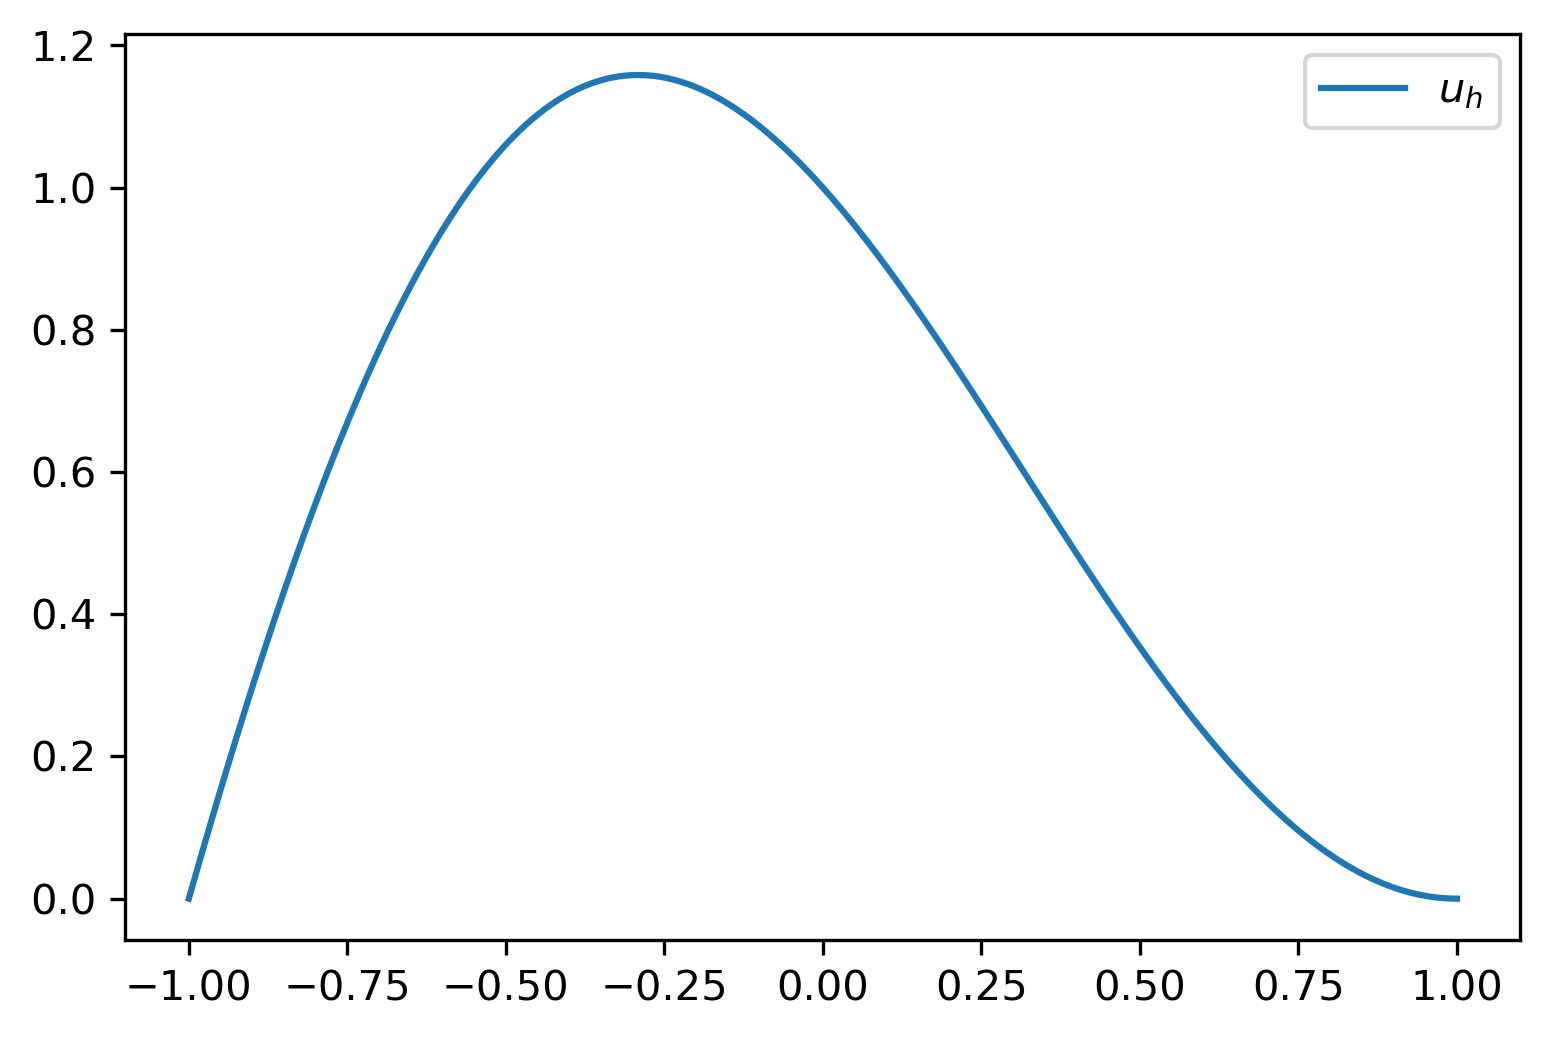

In [40]:
k=1000 #number of finite elements used

x=np.linspace(-1, 1, k+2) #solving the galerkin linear system for problem 2
u_h=np.zeros(k+2)
u_h[1:-1] = galerkin_fast_2(k)

plt.figure(dpi=300) #plotting the result
plt.plot(x, u_h)
plt.legend(['$u_h$'])

### 1.5) Do a numerical convergence analysis of the error of the linear approximations $u_h$ in terms of the mesh-size $h$ . Check that the approximation order is $O(h^2)$. Hint: the unknown functions $u$ can be simulated by taking $u_H$ defined on a very fine mesh with $H\ll h$.

The code is mostly identical to that for Problem 1, but a new parameter `Large` is introduced, which is the number of steps in the approximation we are testing against, which is then compared against `galerkin_fast_2(k)` for all k in `testagainst`. 

In [41]:
def test_galerkin_2(Large=2048, testagainst=np.array([4, 8, 16, 32, 64, 128, 256])):
    '''Performs a numerical convergence analysis for the Galerkin method on problem 2 and plots the result'''
    n=len(testagainst)
    
    knots = np.ones(Large+4) # generating the function with fine meshsize H/large number of finite elements
    knots[1:Large+3]=np.linspace(-1, 1, Large+2)
    knots[0]=-1.0   
    c=np.zeros(Large+2)
    c[1:-1]=galerkin_fast_2(Large)
    E = sp.interpolate.BSpline(knots, c, 1)
    
    x=np.linspace(-1, 1, 2*testagainst[n-1]+2)
    quasi_exact=E(x)
    
    err=[]
    for k in testagainst: # computing the solution for each element in testagainst and finding the error in infinity norm. 
        test=np.zeros(k+2)
        test[1:-1]=galerkin_fast_2(k)
        
        knots = np.ones(k+4)
        knots[1:k+3]=np.linspace(-1, 1, k+2)
        knots[0]=-1.0   
        
        B = sp.interpolate.BSpline(knots, test, 1)
        
        err.append(np.max(np.abs(quasi_exact-B(x))))
    plt.figure(dpi=300) #plotting the vector of errors and a reference succession ~h^2
    plt.semilogy(err, '-o')
    plt.semilogy([i for i in range(n)], [0.09/((testagainst[i]/testagainst[0])**2) for i in range(n)], 'k--o')
    plt.legend(('Error', 'Reference'))
    return np.array(err)

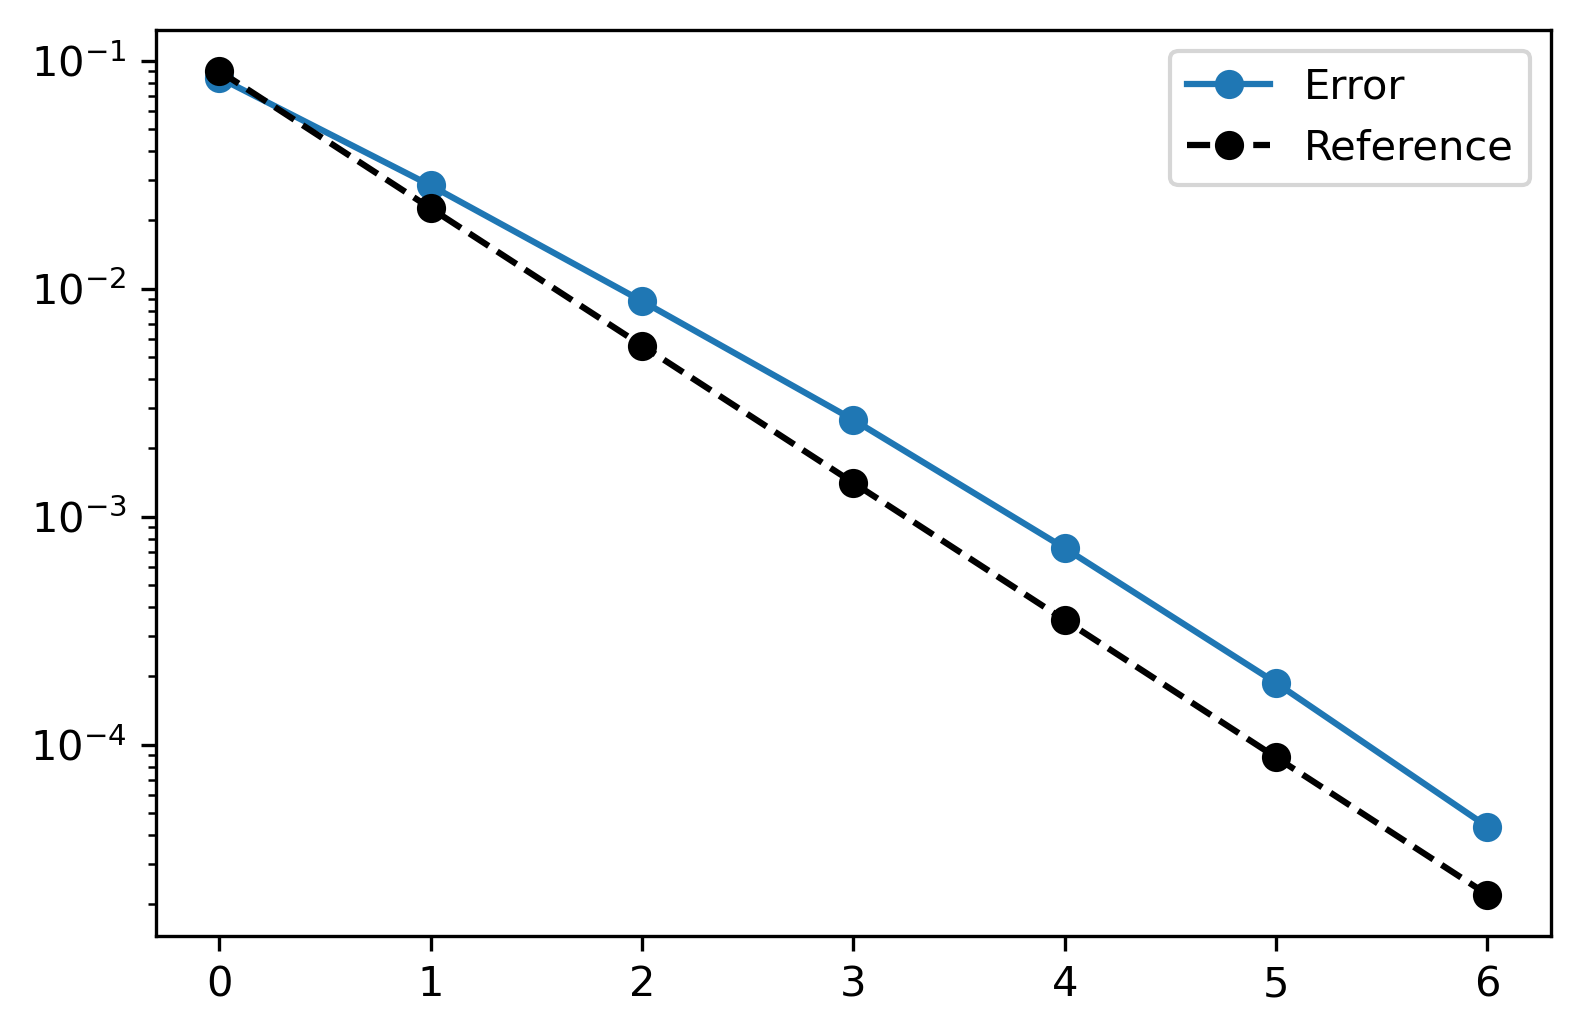

In [42]:
err=test_galerkin_2()

In [43]:
print(np.log2(err[:-1]/err[1:]))

[1.56931662 1.68418788 1.72997278 1.86941977 1.9636641  2.09525203]


# Part 2 - Spline

## Problem 1 - Spline

### 2.1) Visualize a set of B-spline finite elements for different degrees $p\geq1$ (say at least $p=1,2,3$ ) on a given mesh (using a uniform knot sequence in the interval $[0,1]$ ).

The Python to plot the splines is very similar to what we have already used to plot finite elements. We then plot for $p=1,2,3,4$ using a `for` cycle.

In [44]:
def plot_spline(p,n):
    '''Plots n spline functions of degree p from a set of equally distanced knots in [0,1]'''
    x = np.linspace(0, 1, 100*n) #building points to plot the spline in
    knots = np.zeros(n+p+3) #building mesh
    knots[p:n+3]=np.linspace(0, 1, n+3-p)
    knots[n+3:]=np.ones(p)
    for i in range(n): #creating spline element and plotting it 
        spline = ipl.BSpline.basis_element(knots[i+1:i+p+3], extrapolate=False)
        plt.plot(x, spline(x))   
    plt.plot(knots, np.zeros(n+p+3), color='#606060') #plotting knots and line at the bottom
    plt.plot(knots, np.zeros(n+p+3), 'o', color='#000000') 
    plt.title('$%d$-splines'%p)    

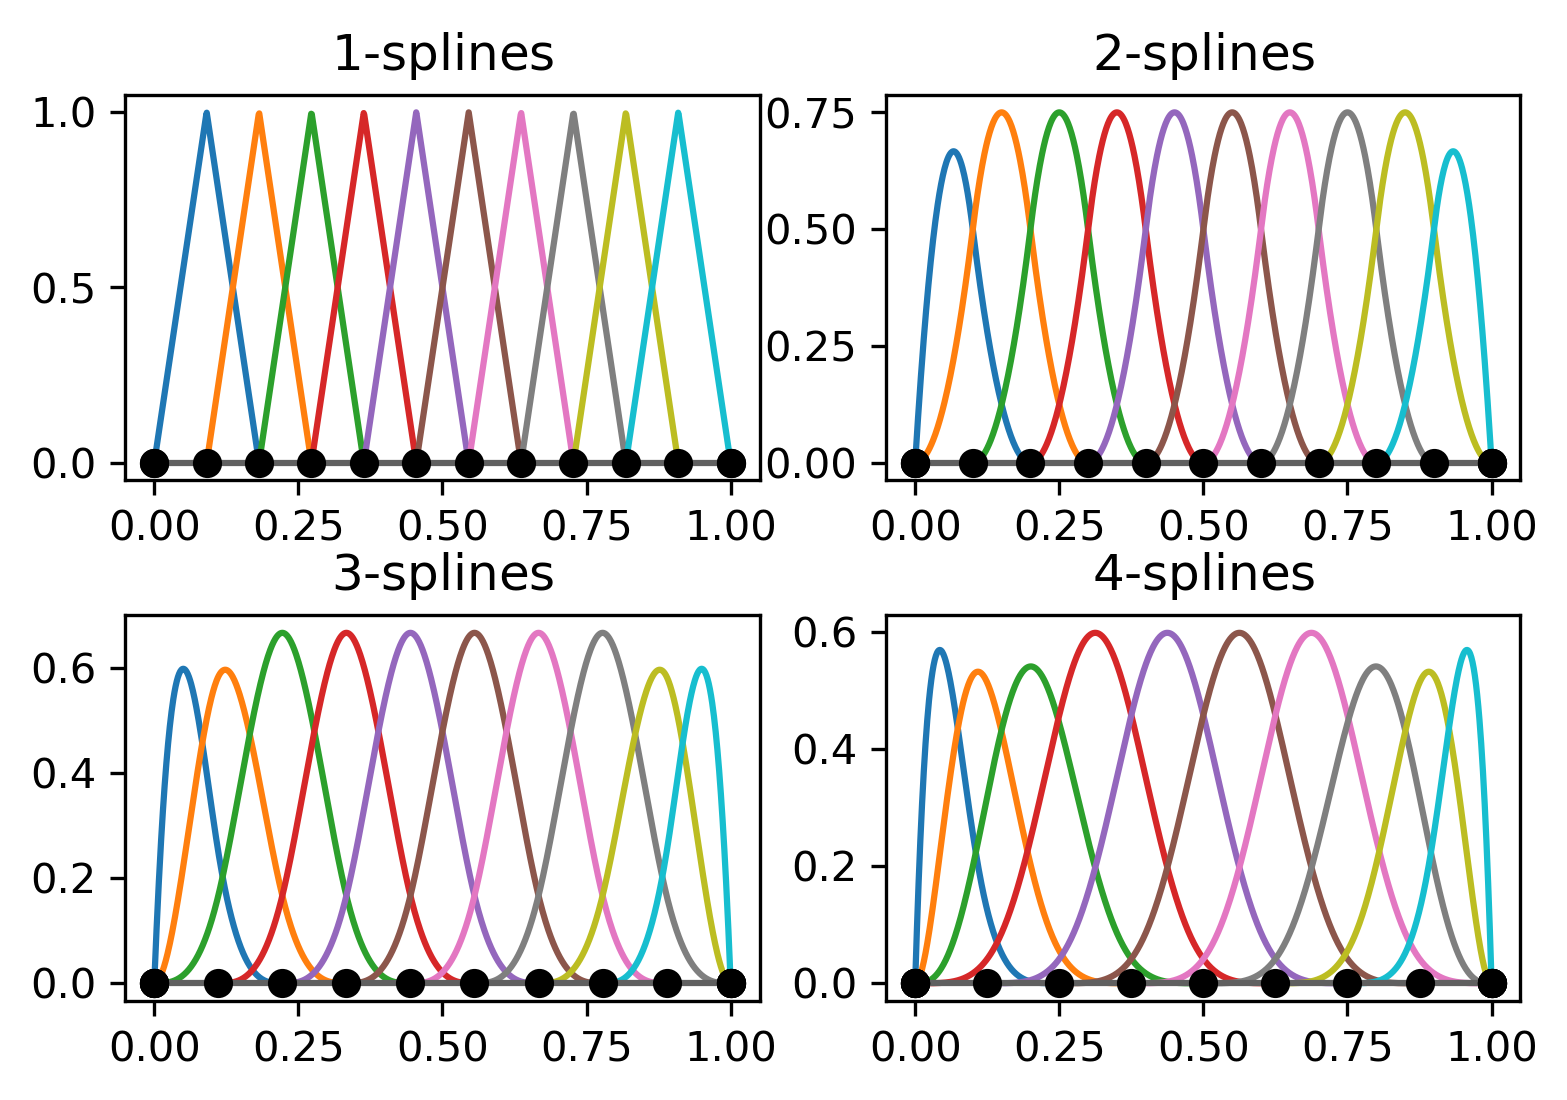

In [45]:
plt.figure(dpi=300)
plt.subplots_adjust(hspace=0.35)#fixes titles overlapping with x values
for p in range(1,5):
    plt.subplot(2,2, p)
    plot_spline(p, 10)

### 2.2) Build the Galerkin linear systems in NumPy format for Problem 1 (and Problem 2), and solve them adequately.

As in the finite elements implementation of Problem 2, we introduce a function `product_f_spline` to compute the integral of the product of $f$ and $\varphi_k$. The only difference is that a new input parameter is introduced to specify the degree of the splines we are using: 

In [46]:
def product_f_spline(n, k, p):
    '''Computes the L^2 scalar product of f and phi_k.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(0, 1, n+3-p)
    knots[0:p]=0
    c=np.zeros(n+2) #allocating the spline
    c[k+1]=1.
    phi=ipl.BSpline(knots, c, p)
    integr=lambda x: compute_f(x)*phi(x) #computing and returning the integral
    return integrate.quad(integr,  knots[k+1], knots[k+2+p])[0] 

Similarly, a function is introduced to compute the $a$-product of $\varphi_{k_1}$ and $\varphi_{k_2}$. Again, the only significant difference is the use of a new parameter $p$ specifying the degree. 

In [47]:
def product_a_spline(n, k1, k2, p):
    '''Computes the a-scalar product of phi_k1 and phi_k2.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(0, 1, n+3-p)
    knots[0:p]=0
    c1=np.zeros(n+2) #first spline
    c1[k1+1]=1.
    phi1=ipl.BSpline(knots, c1, p)
    der1= phi1.derivative(nu=1)
    
    c2=np.zeros(n+2) #second spline
    c2[k2+1]=1.
    phi2=ipl.BSpline(knots, c2, p)
    der2= phi2.derivative(nu=1)
    
    integr=lambda x: phi1(x)*phi2(x)+der1(x)*der2(x) #computing and returning the integral
    return integrate.quad(integr, knots[k1+1],knots[k1+2+p])[0]

The function to solve the linear system is again pretty similar, with only minor changes to allow one to specify the degree of the splines, and adapting ab to have the appropriate number of lines (i.e. diagonals of the matrix): 

In [48]:
def galerkin_spline(n,p):
    '''Solves the Galerkin problem for problem 1 - spline version'''
    ab=np.zeros((1+2*p,n)) #computing the matrix A
    for i in range(0, n):
        ab[p, i]= product_a_spline(n, i, i, p)
    for j in range(1,p+1): 
        for i in range(0, n-j):
            ab[p-j, i+j]= product_a_spline(n, i, i+j, p) 
            ab[p+j, i]=ab[p-j, i+j]
    f=[product_f_spline(n,i,p) for i in range(0,n)] #computing the vector F
    x=sp.linalg.solve_banded((p, p), ab, f) #solving the Galerkin system and returning the result
    return x

In [49]:
print(galerkin_spline(100, 2))

[ 3.14278348e-02  9.41406298e-02  1.56425538e-01  2.17999756e-01
  2.78584146e-01  3.37904678e-01  3.95693836e-01  4.51692000e-01
  5.05648777e-01  5.57324282e-01  6.06490368e-01  6.52931790e-01
  6.96447294e-01  7.36850640e-01  7.73971536e-01  8.07656489e-01
  8.37769566e-01  8.64193056e-01  8.86828039e-01  9.05594850e-01
  9.20433439e-01  9.31303625e-01  9.38185247e-01  9.41078198e-01
  9.40002360e-01  9.34997424e-01  9.26122608e-01  9.13456266e-01
  8.97095397e-01  8.77155048e-01  8.53767631e-01  8.27082130e-01
  7.97263235e-01  7.64490382e-01  7.28956717e-01  6.90867986e-01
  6.50441359e-01  6.07904192e-01  5.63492737e-01  5.17450802e-01
  4.70028375e-01  4.21480215e-01  3.72064421e-01  3.22040980e-01
  2.71670315e-01  2.21211824e-01  1.70922439e-01  1.21055190e-01
  7.18578023e-02  2.35713226e-02 -2.35712154e-02 -6.93460749e-02
 -1.13540046e-01 -1.55951615e-01 -1.96392061e-01 -2.34686480e-01
 -2.70674731e-01 -3.04212286e-01 -3.35171001e-01 -3.63439779e-01
 -3.88925144e-01 -4.11551

### 2.3) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$.

The code to plot is again mostly copy-paste with slight adjustments to allow a higher degree. This time we write a function to test a couple of different degrees. 

In [50]:
def visualize(n, p):
    '''Plots the solution to the Galerkin linear system for problem 1, approximated with n splines of degree p.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(0, 1, n+3-p)
    knots[0:p]=0
    x=np.linspace(0, 1, 10*n) #values where we evaluate the solution
    c=np.zeros(n+2)
    c[1:-1]=galerkin_spline(n, p) #solving the Galerkin linear system
    u_h=ipl.BSpline(knots, c, p) 
    plt.figure(dpi=300) #plotting the solution and the exact solution 
    plt.plot(x, u_h(x))
    plt.plot(x, (1-x**2)*np.sin(2*np.pi*x))
    plt.legend(['$u_h$', '$(1-x^2)\sin(2 \pi x)$'])

We could make this more compact with subplots, but I like the bigger graphs. 

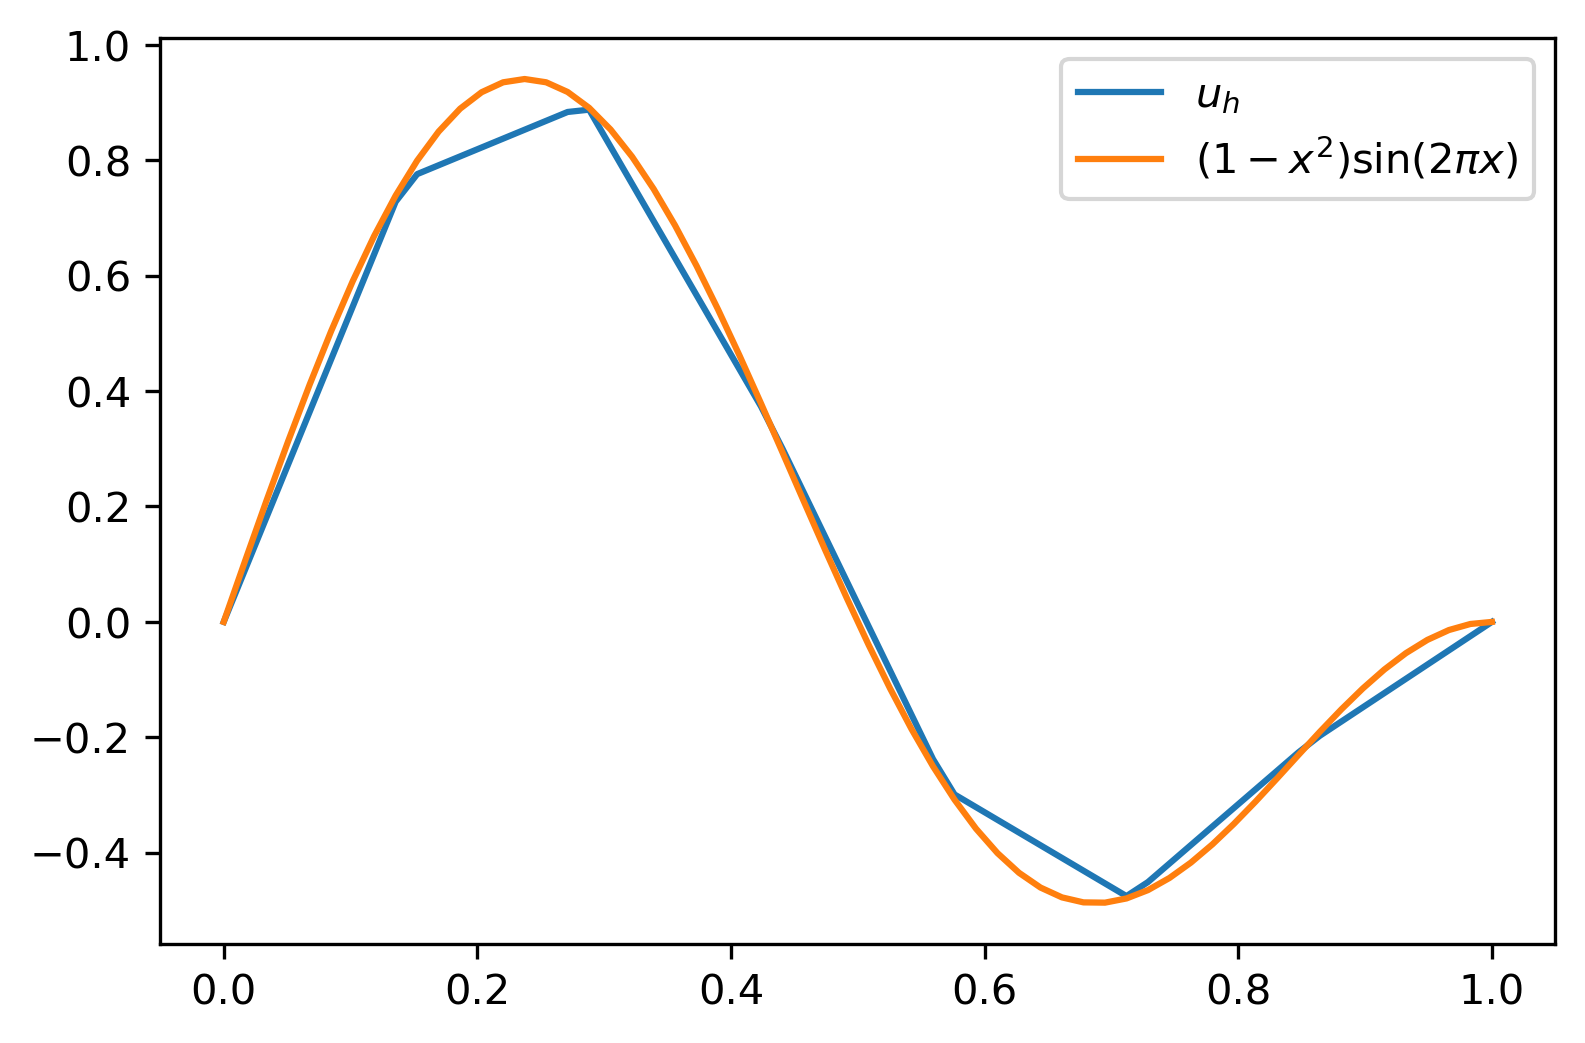

In [51]:
visualize(6, 1)

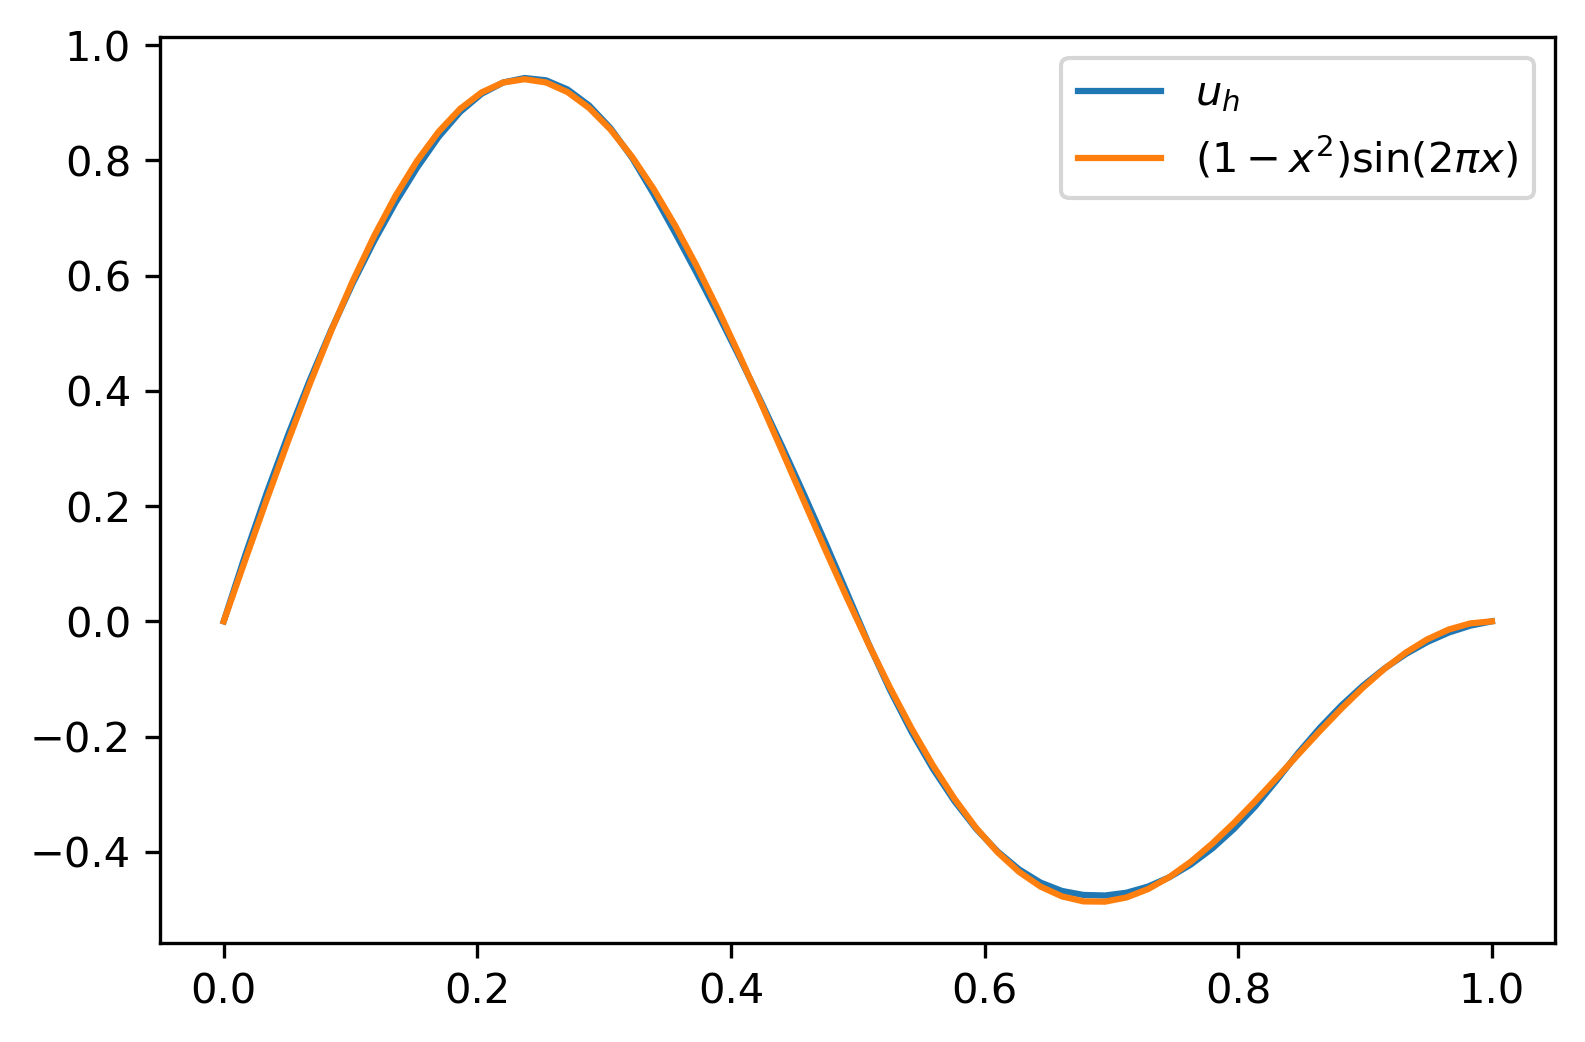

In [52]:
visualize(6, 2)

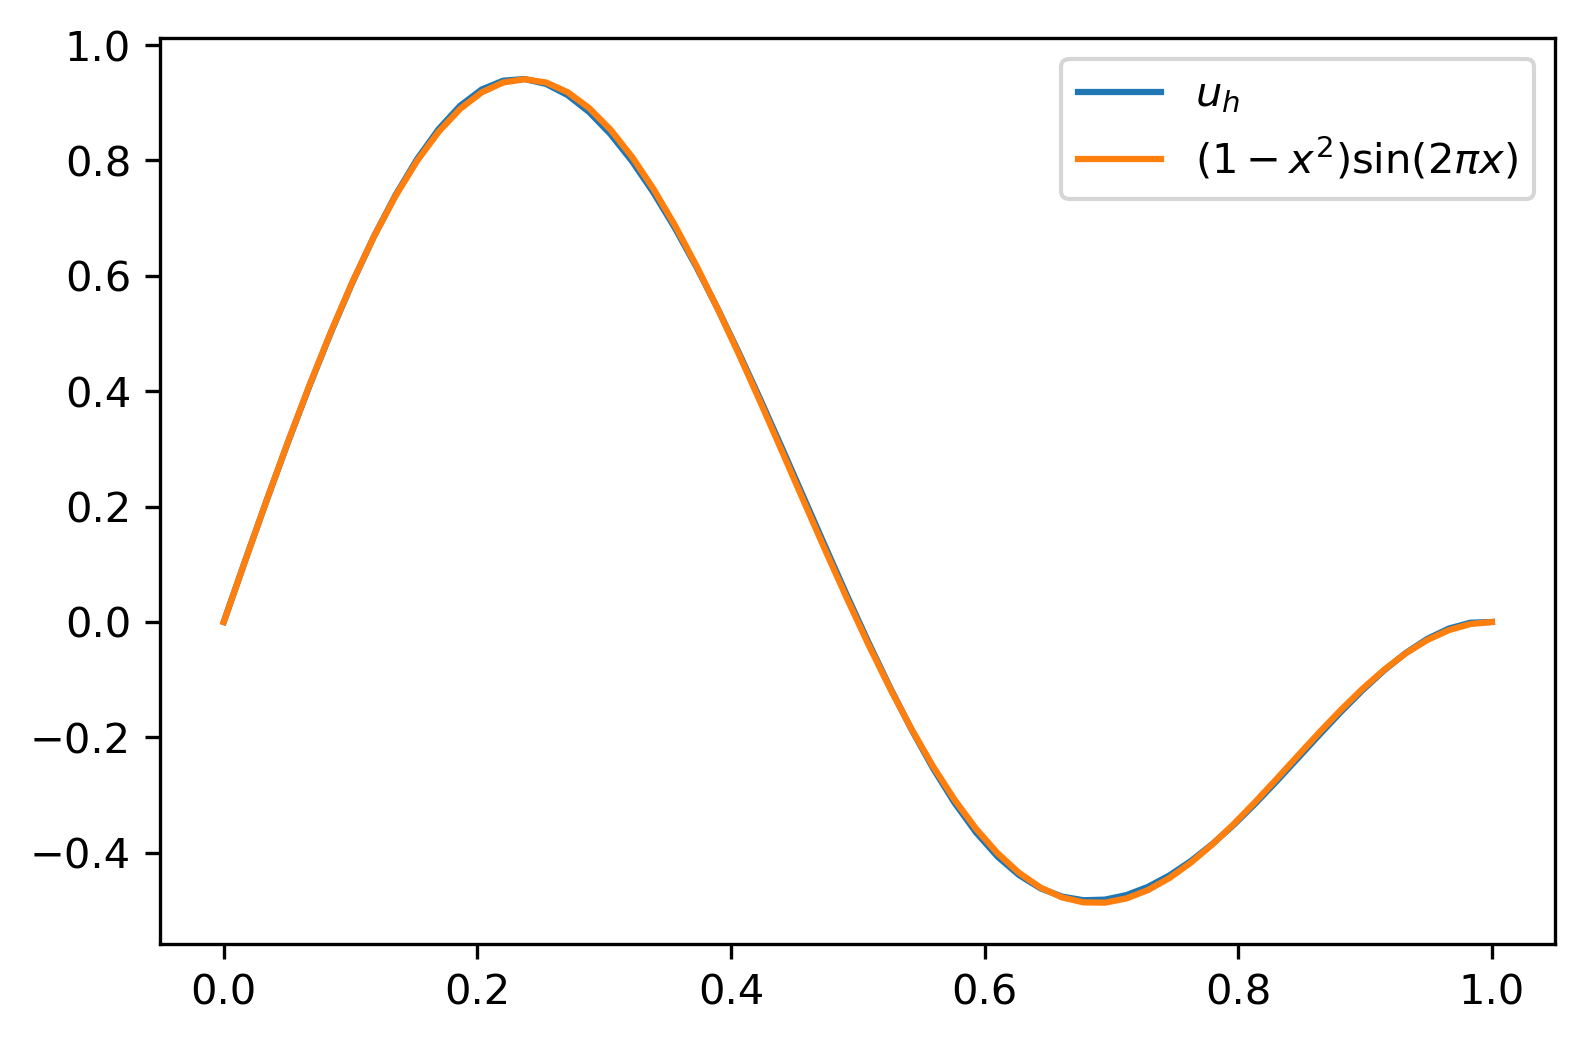

In [53]:
visualize(6, 3)

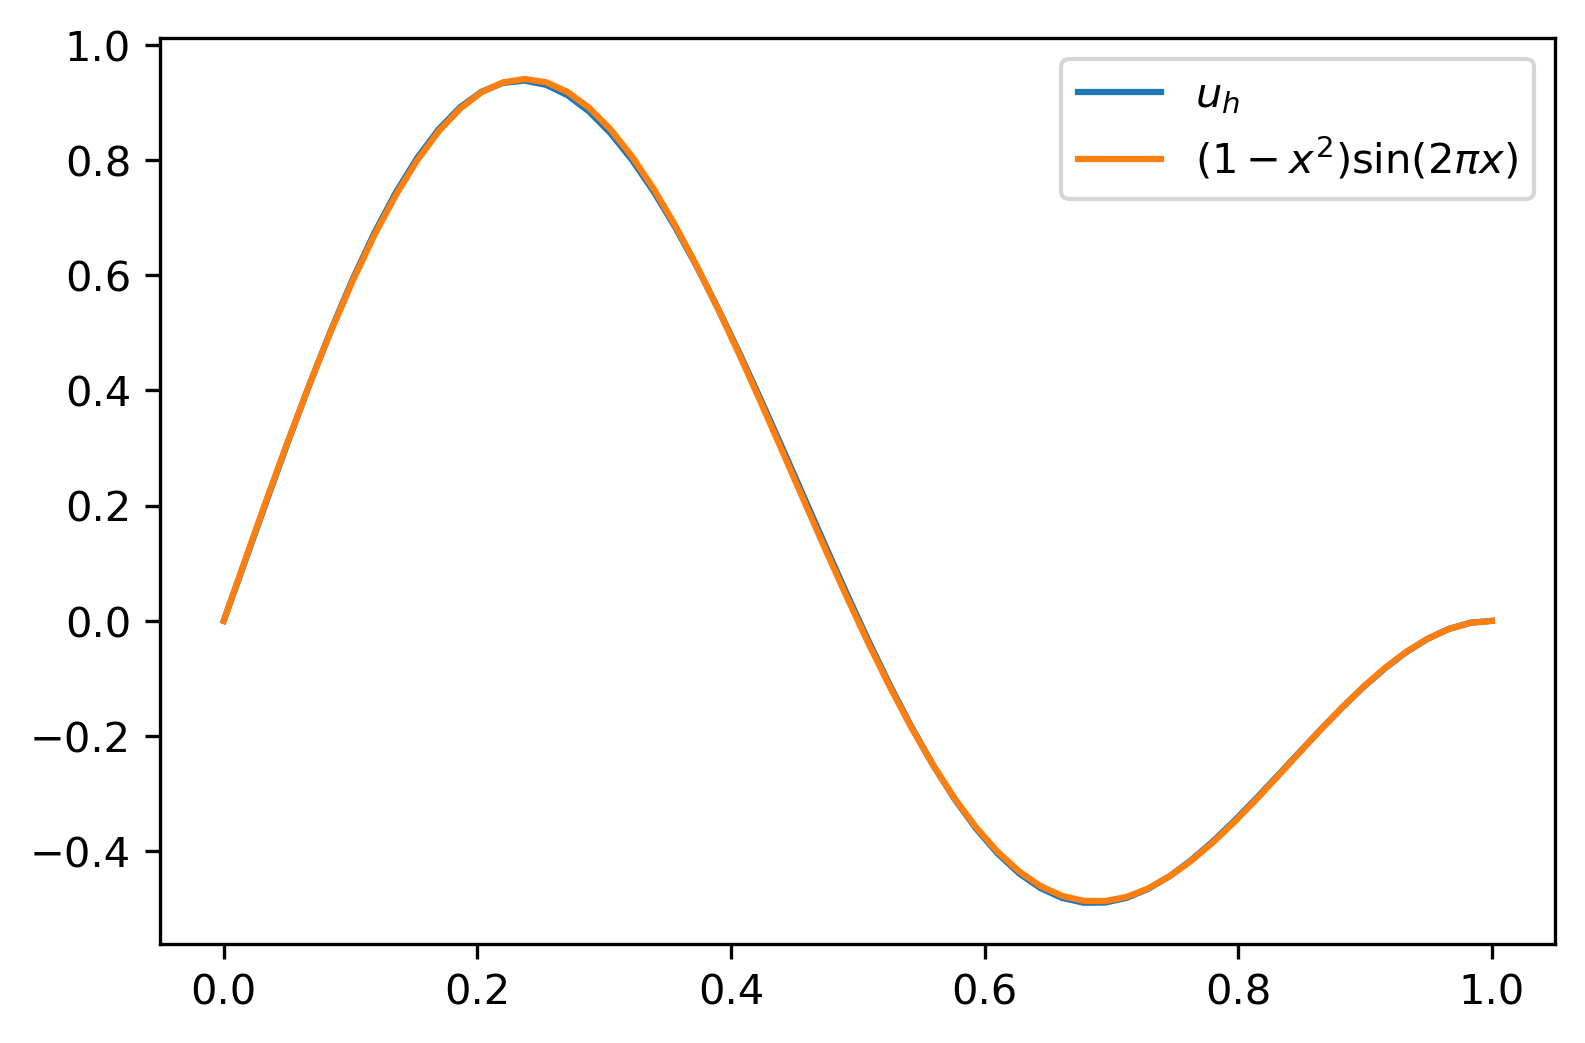

In [54]:
visualize(6, 4)

The interpolation becomes remarkably precise when the degree of the interpolating splines goes up, even with a low number of knots. The difference between $p=1$ and $p=2$ is particularly striking.  

### 2.4) Do a numerical convergence analysis of the error of the spline approximations $u_h$ in terms of the mesh-size $h$ for different degrees $p\geq1$ . What is the approximation order? How does it depend on the spline degree $p$ ?

The function to analyze the error is not much dissimilar to that of Part 1, but it is updated to allow the user to choose a degree. The numbers have also been dialed down a notch to get reasonable execution times. 

In [55]:
def test_galerkin_spline(p, testagainst=np.array([4, 8, 16, 32, 64, 128, 256])):
    '''Performs a numerical convergence analysis for the Galerkin method on problem 1 and plots the result - spline version'''
    n=len(testagainst)
    
    x=np.linspace(0, 1, 2*testagainst[n-1]+2) #exact solution
    exact=(1-x**2)*np.sin(2*np.pi*x)
    err=[]
    for k in testagainst:
        test=np.zeros(k+2) #solve the Galerkin linear system
        test[1:-1]=galerkin_spline(k,p)
        
        knots = np.ones(k+p+3) #knots in the meshes
        knots[p:-p]=np.linspace(0, 1, k+3-p)
        knots[0:p]=0.   
        
        B = sp.interpolate.BSpline(knots, test, p) #creating the resolving interpolating spline
        err.append(np.max(np.abs(exact-B(x)))) #computing and appending the error on the step
    plt.figure(dpi=300) #plotting the results
    plt.semilogy(err, '-o')
    plt.semilogy([0.08/((testagainst[i]/testagainst[0])**(p+1)) for i in range(n)], 'k--o')
    plt.legend(('Error', 'Reference'))
    return np.array(err)

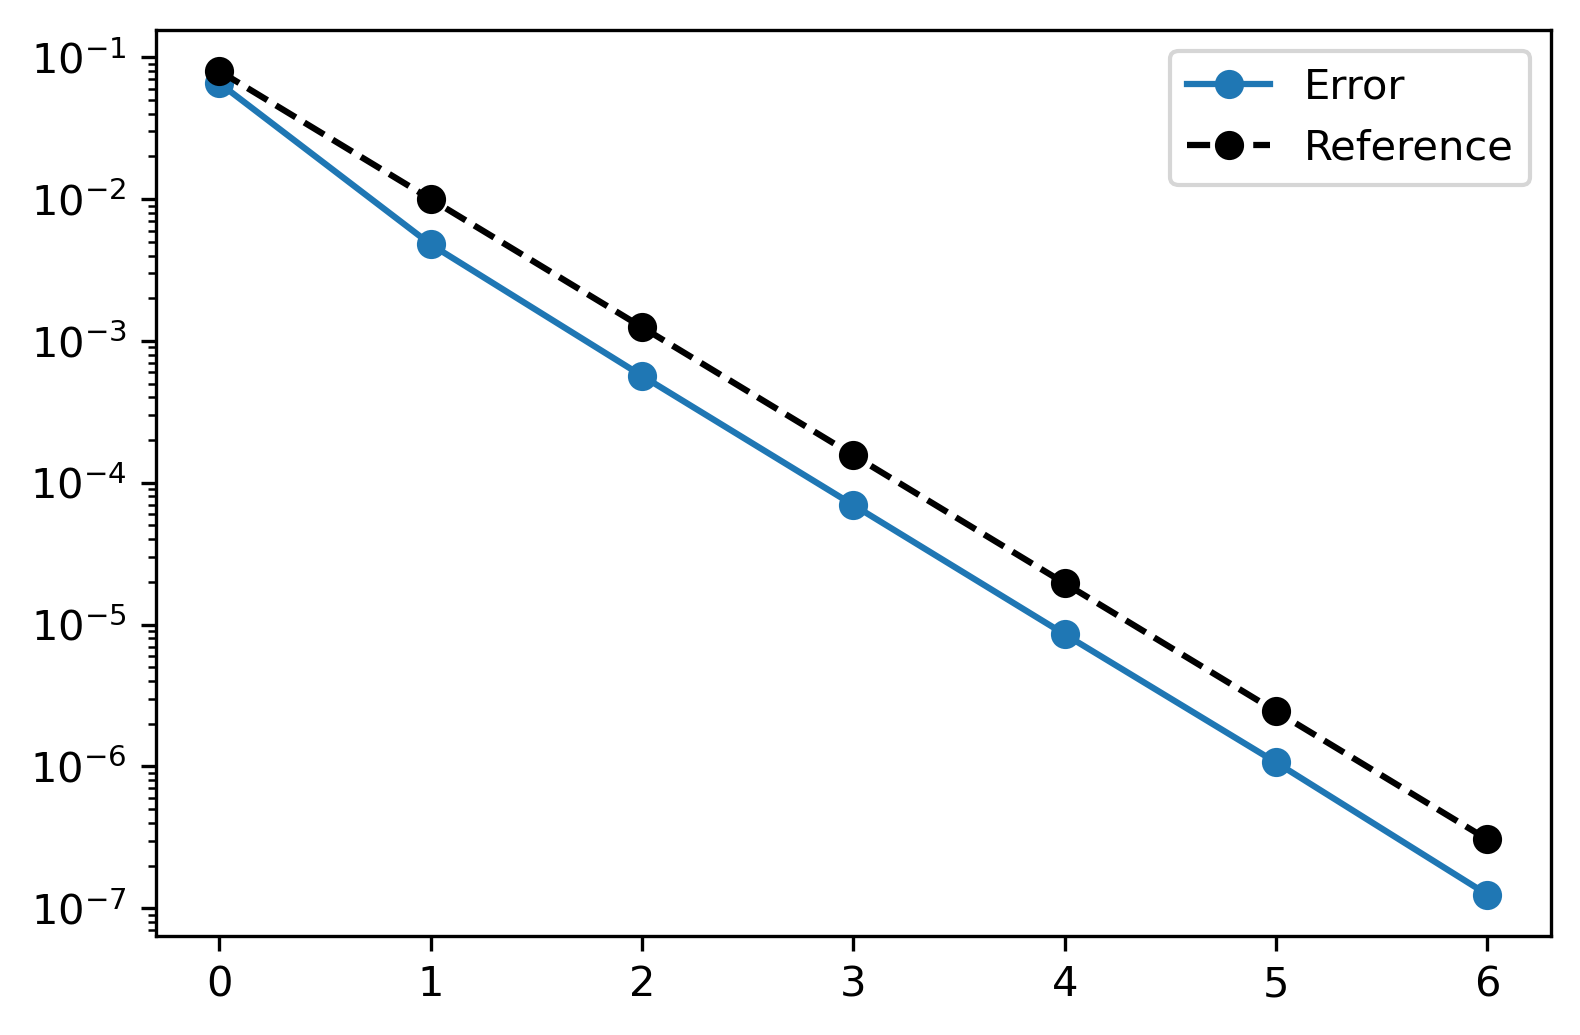

In [56]:
err_spline=test_galerkin_spline(2)

In [57]:
print(np.log2(err_spline[:-1]/err_spline[1:]))

[3.77878753 3.07907372 3.02761915 3.02773467 3.00120354 3.09624458]


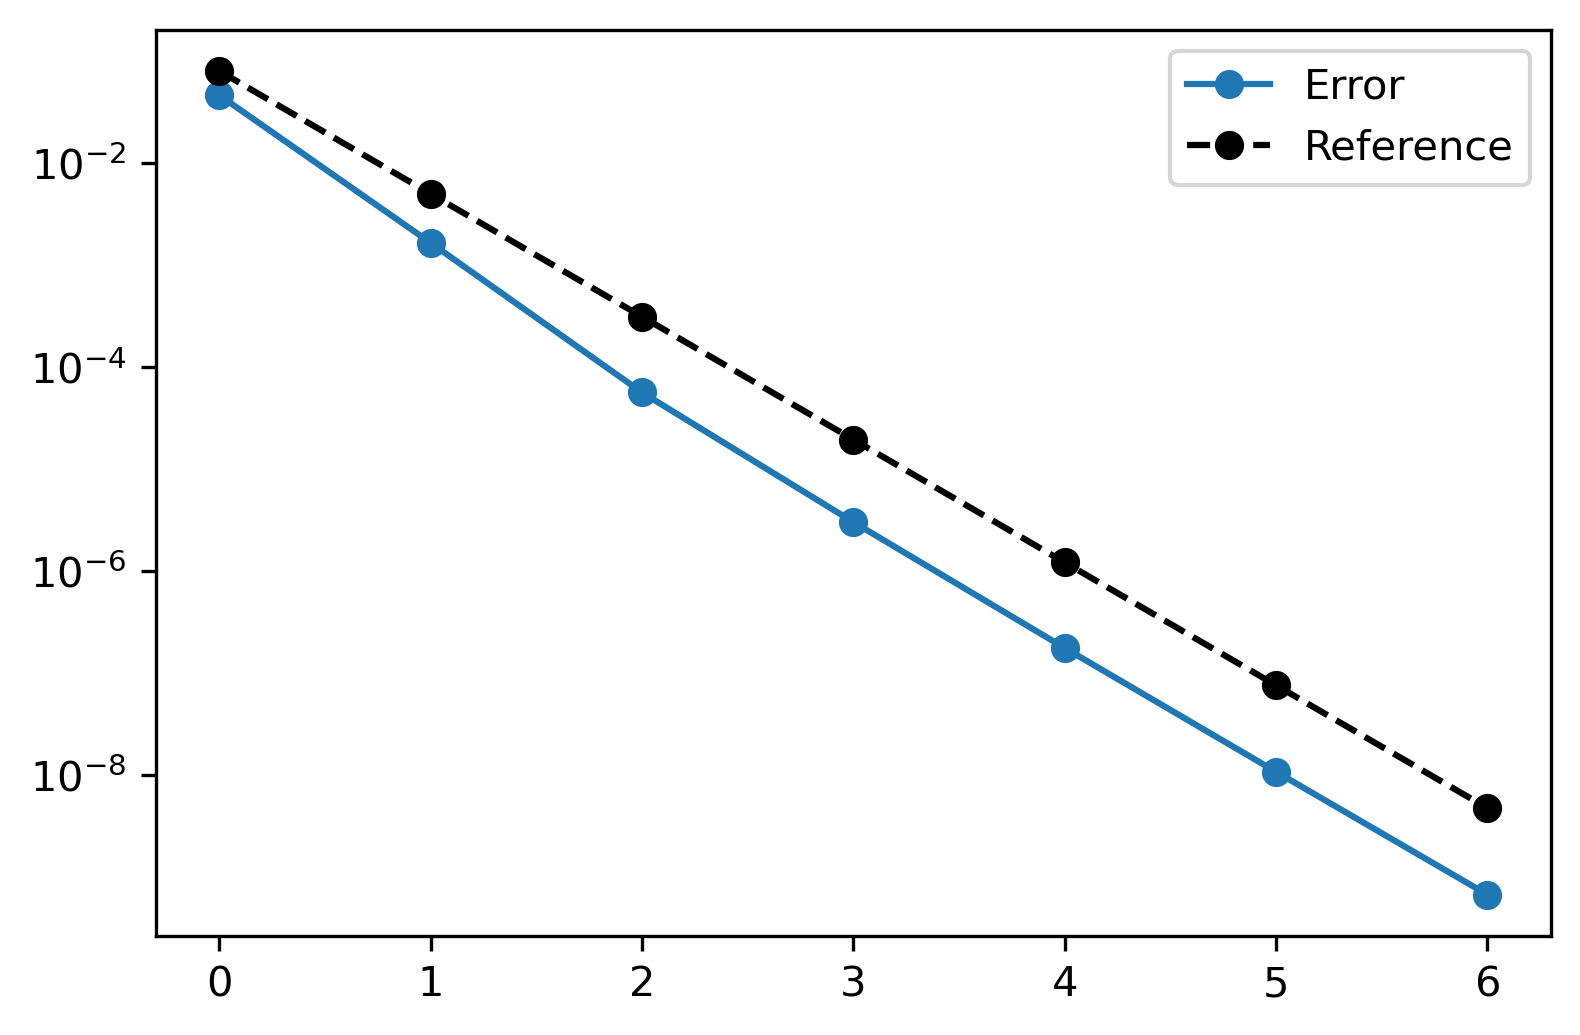

In [58]:
err_spline_tre=test_galerkin_spline(3)

In [59]:
print(np.log2(err_spline_tre[:-1]/err_spline_tre[1:]))

[4.80826784 4.87074032 4.22039001 4.09911715 4.03091466 3.99901469]


As one can see, and confirm with further testing, the error is the size of $O(h^{p+1})$, thus a higher spline degree converges much faster to the solution (however also at a higher computational cost). This matches with what we expected from the theory. 

## Problem 2 - Spline

### 2.2) Build the Galerkin linear systems in NumPy format for (Problem 1 and) Problem 2, and solve them adequately.

We introduce again the usual function to compute $\int_{[0,1]} f \phi_k dx$ and to compute $a( \phi_{k_1}, \phi_{k_2})$: 

In [60]:
def product_f_2_spline(n, k, p):
    '''Computes the scalar product of f and phi_k.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(-1, 1, n+3-p)
    knots[0:p]=-1
    c=np.zeros(n+2) #allocating the spline
    c[k+1]=1.
    phi=ipl.BSpline(knots, c, p)
    integr=lambda x: compute_f_2(x)*phi(x) #computing the integral
    return integrate.quad(integr,  knots[k+1], knots[k+2+p])[0] 

In [61]:
def product_a_spline_2(n, k1, k2, p):
    '''Computes the a-scalar product of phi_k1 and phi_k2.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(-1, 1, n+3-p)
    knots[0:p]=-1
    c1=np.zeros(n+2) #allocating the first spline
    c1[k1+1]=1.
    phi1=ipl.BSpline(knots, c1, p)
    der1= phi1.derivative(nu=1)
    
    c2=np.zeros(n+2) #allocating the second spline
    c2[k2+1]=1.
    phi2=ipl.BSpline(knots, c2, p)
    der2= phi2.derivative(nu=1)
    
    integr=lambda x: 2*x*phi1(x)*phi2(x)+np.sin(np.pi*x*0.5)*der1(x)*der2(x) #computing the integral 
    return integrate.quad(integr, knots[k1+1],knots[k1+2+p])[0]

And the solver for the Galerkin problem, which is identical to the one for problem 1, with the appropriate new functions: 

In [62]:
def galerkin_spline_2(n,p):
    '''Solves the Galerkin problem for problem 2 - spline version'''
    ab=np.zeros((1+2*p,n)) #computing the matrix A
    for i in range(0, n):
        ab[p, i]= product_a_spline_2(n, i, i, p)
    for j in range(1,p+1): 
        for i in range(0, n-j):
            ab[p-j, i+j]= product_a_spline_2(n, i, i+j, p) 
            ab[p+j, i]=ab[p-j, i+j]
    f=[product_f_2_spline(n,i,p) for i in range(0,n)] #computing the vector F
    x=sp.linalg.solve_banded((p, p), ab, f) #solving the Galerkin system and returning the result
    return x

In [63]:
galerkin_spline_2(10, 3)

array([ 2.32833395e-01,  6.45309211e-01,  1.04071143e+00,  1.19161833e+00,
        1.12130934e+00,  8.88759253e-01,  5.75999902e-01,  2.71271215e-01,
        5.27668987e-02, -1.22984089e-04])

### 2.3) Visualize the obtained solutions $u_h$ approximating the unknown functions $u$.

Once again, the code is identical to Problem 1, with only minor adjustments:

In [64]:
def visualize_2(n, p):
    '''Plots the solution to the Galerkin linear system for problem 2, approximated with n splines of degree p.'''
    knots=np.ones(n+p+3) #knots in the mesh
    knots[p:-p]=np.linspace(-1, 1, n+3-p)
    knots[0:p]=-1
    x=np.linspace(-1, 1, 10*n+2) #values where we evaluate the solution
    c=np.zeros(n+2)
    c[1:-1]=galerkin_spline_2(n, p) #solving the Galerkin system
    u_h=ipl.BSpline(knots, c, p) #allocating the resulting spline 
    plt.figure(dpi=300) #plotting the solution
    plt.plot(x, u_h(x))
    plt.legend(['$u_h$', '$(1-x^2)\sin(2 \pi x)$'])

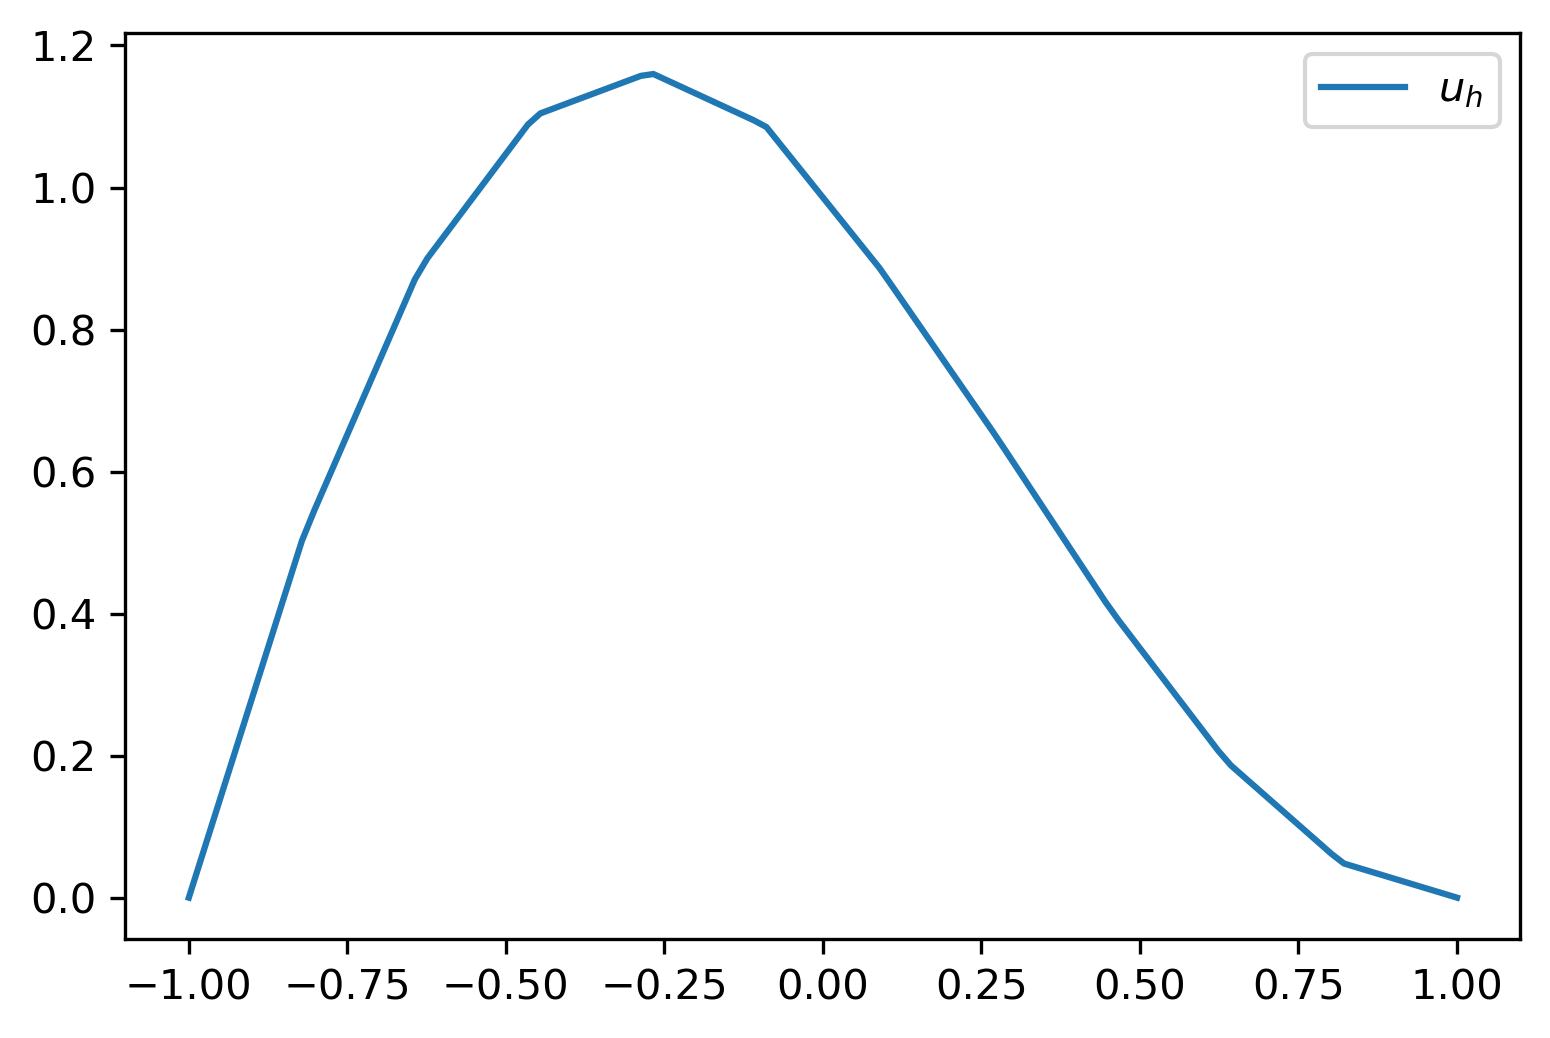

In [65]:
visualize_2(10, 1)

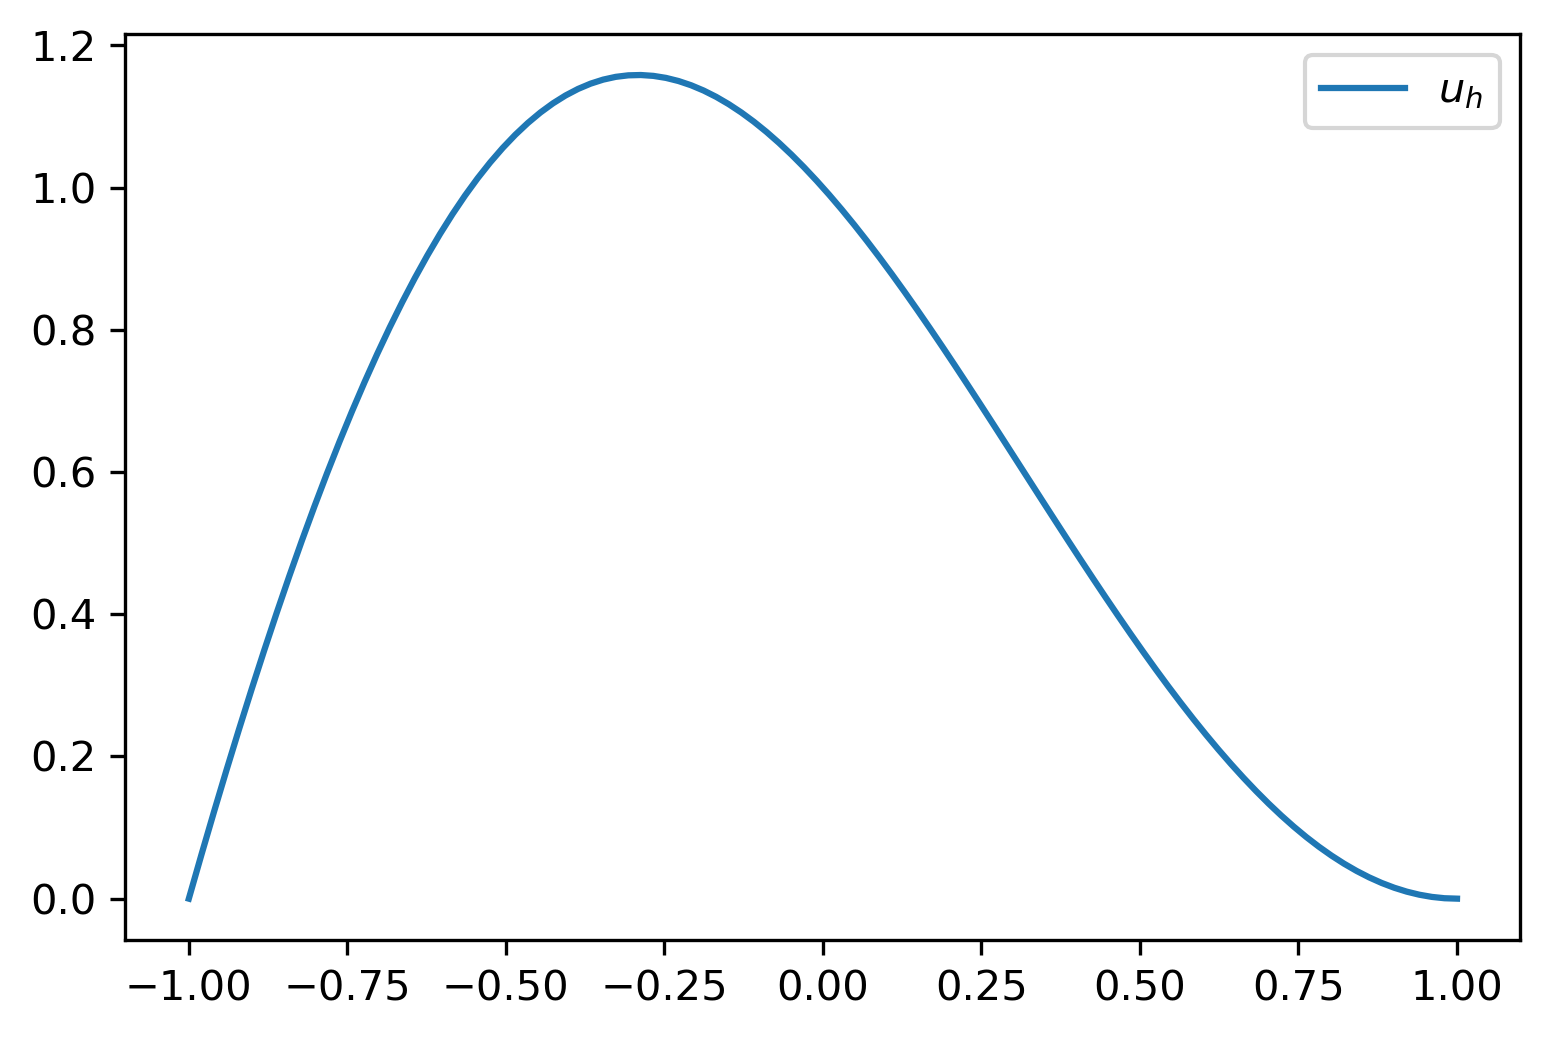

In [66]:
visualize_2(10, 3)

### 2.4) Do a numerical convergence analysis of the error of the spline approximations $u_h$ in terms of the mesh-size $h$ for different degrees $p\geq1$ . What is the approximation order? How does it depend on the spline degree $p$ ?

Again, it is all extremely similar to Problem 1: 

In [67]:
def test_galerkin_spline_2(p, Large=1024, testagainst=np.array([4, 8, 16, 32, 64])):
    '''Performs a numerical convergence analysis for the Galerkin method on problem 2 and plots the result - spline version'''
    n=len(testagainst)
    
    knots = np.ones(Large+p+3) #knots in the finer mesh
    knots[p:-p]=np.linspace(-1, 1, Large+3-p)
    knots[0:p]=-1
    c=np.zeros(Large+2)
    c[1:-1]=galerkin_spline_2(Large,p) #solving the Galerkin linear system on the finer mesh
    E = sp.interpolate.BSpline(knots, c, p) #Allocating the large resolving spline
    
    x=np.linspace(-1, 1, 2*Large+2) #computing the approximation of the solution
    quasi_exact=E(x) 
    
    err=[]
    for k in testagainst:
        test=np.zeros(k+2) #solving the galerkin problem for each k in testagainst
        test[1:-1]=galerkin_spline_2(k,p)
        
        knots = np.ones(k+p+3) #knots in the coarser meshes
        knots[p:-p]=np.linspace(-1, 1, k+3-p)
        knots[0:p]=-1   
        
        B = sp.interpolate.BSpline(knots, test, p) #solving the Galerkin linear system on the smaller meshes
        
        err.append(np.max(np.abs(quasi_exact-B(x)))) #computing the error 
    plt.figure(dpi=300) #plotting 
    plt.semilogy(err, '-o')
    plt.semilogy([i for i in range(n)], [0.03/((testagainst[i]/testagainst[0])**(p+1)) for i in range(n)], 'k--o')
    plt.legend(('Error', 'Reference'))
    return np.array(err)

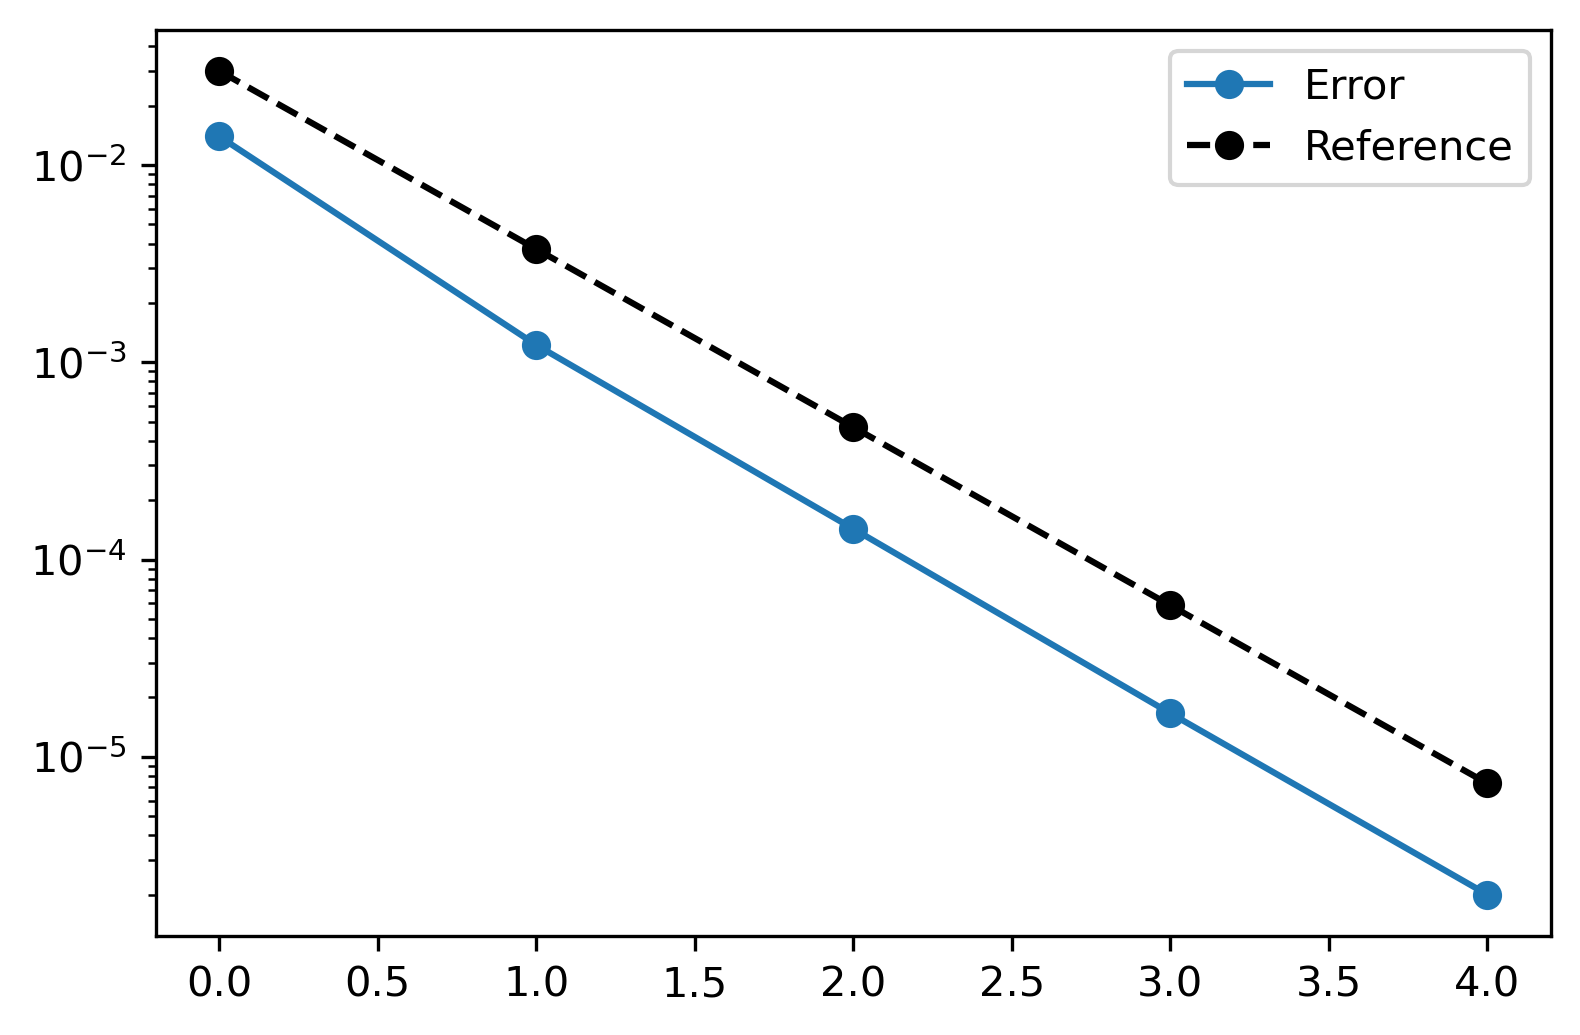

In [68]:
err_spl_2=test_galerkin_spline_2(2)

In [69]:
print(np.log2(err_spl_2[:-1]/err_spl_2[1:]))

[3.51288472 3.09643933 3.10681568 3.05374932]


As we can see, Problem 2 has the same pattern with respect to the approximation order as Problem 1. (i.e. error $\sim O(h^{p+1})$) 